## Converting The Sensor Data to Magnetometer Readings

The magnetometer is an [FGM-3](https://docs.wixstatic.com/ugd/7034a0_423d3603cbfe4be1a2d0bf013b1a1513.pdf) sensor and raw data from it is recorded as 3 column ``.csv`` files. The raw sensor data consists of 3 values; a timestamp, a number between 0 and 65534 representing a frequency and the temperature reading.

The geomagnetic field reading depends on the frequency output from the sensor. However, the sensor readings are also sensitive to temperature. Therefore, first, the number representing a frequency needs converting to a frequency, then the effect of temperature needs removing from the frequency and then the frequency needs converting to a magnetic field reading.

There are several steps involved in converting these sensor readings into magnetometer variometer data, which this notebook goes through.

### 1. Import relevant libraries.

In [1]:
# Import the required libraries.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn import mixture
from datetime import datetime, timedelta
from lmfit import Model

from cpdetect import cpDetector

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams.update({"font.size": 22})

import json
import igrf12

### 2. Load the data into a pandas dataframe.

First, reload all the magnetometer data in the ``.csv``s, generated using the [Magnetometer_Data_Preprocessing](Magnetometer_Data_Preprocessing.ipynb) notebook. Invalid readings are also removed.

In [2]:
# Set the path to the csv files.
dat_fp = "csvs/"
# Load data retrieved from 2011 to 2018.
years = ["2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]

mag_dat = {}
# Load in all the csv's.
for year in years:
    mag_dat[year] = pd.read_csv(dat_fp+year+"_mag_dat.csv",
                                dtype={"time": np.object_,
                                       "reading": np.float64,
                                       "temperature": np.float64})
    mag_dat[year]["time"] = pd.to_datetime(mag_dat[year]["time"],format="%Y-%m-%d %H:%M:%S")

# Concatenate the separate yearly results.
all_mag_dat = pd.concat(mag_dat.values())
# Set the time column as the index (used for downsampling).
all_mag_dat.set_index("time", inplace=True)
# Remove invalid readings.
all_mag_dat = all_mag_dat.loc[(all_mag_dat["reading"] >= 0) & (all_mag_dat["reading"] <= 65534)]

del mag_dat
all_mag_dat.head()

reading  temperature
time                                     
2011-10-26 23:00:05  31896.0       21.343
2011-10-26 23:00:08  31896.0       21.342
2011-10-26 23:00:11  31896.0       21.333
2011-10-26 23:00:14  31896.0       21.346
2011-10-26 23:00:17  31896.0       21.356

#### Resampling the data.
The raw data is quite noisy and takes a lot of memory. Both of these problems can be solved by downsampling the data to 1 sample per minute, by taking minute means. The data is also downsampled at 1 sample per hour, for detecting "step changes" in the data.

Note: when doing a mean resample using pandas, the resampled minute at a given time is all the times from that minute up to (but not including) the minute after. E.g. a minute resample at t=10:22 is the average of all the times $10:22 \le t \lt 10:23$ (see [pandas resampling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).)

Downsample the data:

In [3]:
mag_dat_1h = all_mag_dat.resample('1h').mean()
mag_dat_1h.dropna(inplace=True)
all_mag_dat = all_mag_dat.resample('1T').mean()
all_mag_dat.dropna(inplace=True)

Get information about the currently loaded dataframes:

In [4]:
# Get info about the data sampled every 1 hour.
def get_df_info(df):
    df.info(memory_usage="deep")
    for dtype in [np.float64,'datetime64']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("\nAverage memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

get_df_info(mag_dat_1h)
get_df_info(all_mag_dat)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25946 entries, 2011-02-01 12:00:00 to 2018-06-30 09:00:00
Data columns (total 2 columns):
reading        25946 non-null float64
temperature    25946 non-null float64
dtypes: float64(2)
memory usage: 608.1 KB

Average memory usage for <class 'numpy.float64'> columns: 0.20 MB

Average memory usage for datetime64 columns: 0.20 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1554574 entries, 2011-02-01 12:02:00 to 2018-06-30 09:29:00
Data columns (total 2 columns):
reading        1554574 non-null float64
temperature    1554574 non-null float64
dtypes: float64(2)
memory usage: 35.6 MB

Average memory usage for <class 'numpy.float64'> columns: 11.86 MB

Average memory usage for datetime64 columns: 11.86 MB


### 3. Plot the raw sensor data and temperature against time.

The raw sensor data plot shows significant gaps in the readings and large step changes. In its current form, it cannot be converted into magnetic field readings. First, the data needs to be separated where there are step changes and time discontinuities.

A strange error shows up in the temperature plot. The temperatures appear to be cut off at about 30C, then "loop back" to 0C afterwards. This will need correcting, before magnetometer readings can be extracted.

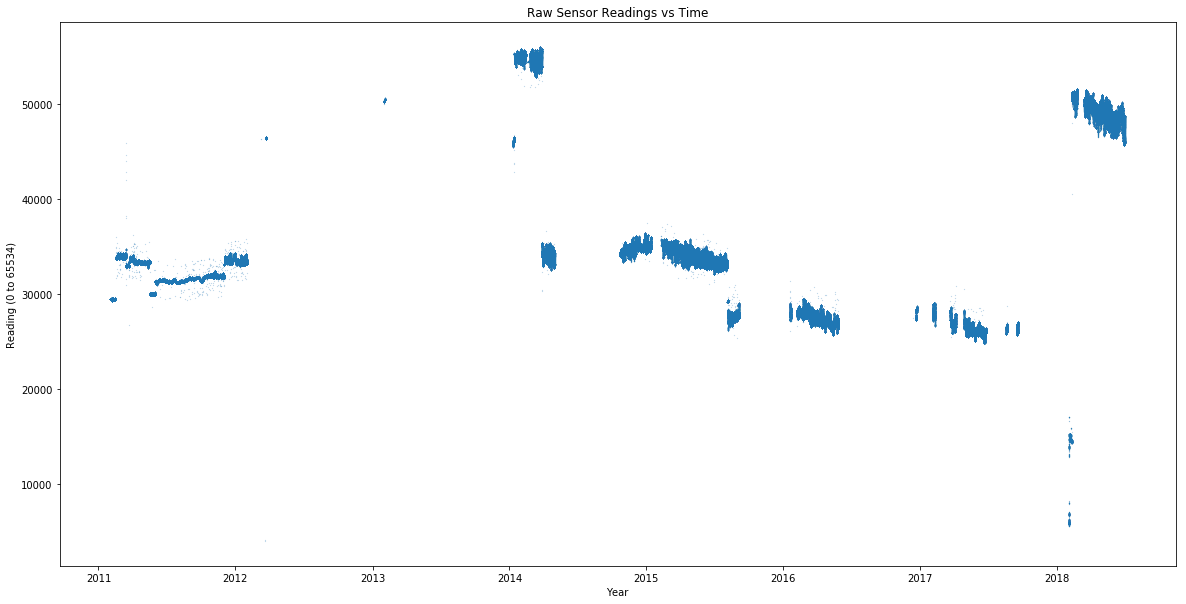

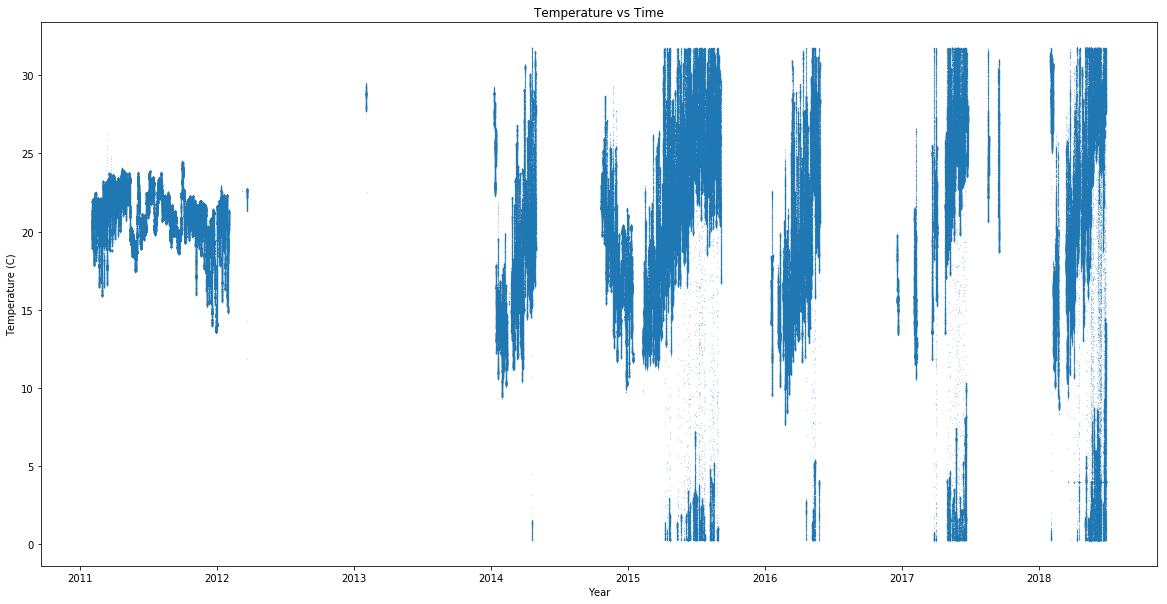

In [5]:
plt.figure(figsize=(20,10))
plt.title("Raw Sensor Readings vs Time")
plt.xlabel("Year")
plt.ylabel("Reading (0 to 65534)")
plt.plot(all_mag_dat["reading"], 'o', ms=0.1)
plt.figure(figsize=(20,10))
plt.title("Temperature vs Time")
plt.xlabel("Year")
plt.ylabel("Temperature (C)")
plt.plot(all_mag_dat["temperature"], 'o', ms=0.1)

### 4. Detecting step change points.

The data needs splitting where significant "jumps" or discontinuities occur, because this means the sensor has been re-calibrated and this will have an effect on the temperature dependency of readings. Therefore, different temperature dependencies are fitted where there is a step change in the data. Step changes can be detected using bayesian changepoint detection. The Algorithm cannot handle large quantities of data, so the 1 hour-sampled data is used. (Note that this means the step detection accuracy is only every 1 hour, so some results will be corrupted by this.)

20:06:37 INFO cpDetector: =======================================
20:06:37 INFO cpDetector: Running change point detector
20:06:37 INFO cpDetector: =======================================
20:06:37 INFO cpDetector:    input observations: 1 of length [25946]
20:06:37 INFO cpDetector: Running cp detector on traj 0
20:06:37 INFO cpDetector: ---------------------------------
20:07:08 INFO cpDetector:     Found a new change point at: 8741!!
20:07:18 INFO cpDetector:     Found a new change point at: 7264!!
20:07:25 INFO cpDetector:     Found a new change point at: 2846!!
20:07:28 INFO cpDetector:     Found a new change point at: 325!!
20:07:31 INFO cpDetector:     Found a new change point at: 2512!!
20:07:33 INFO cpDetector:     Found a new change point at: 965!!
20:07:35 INFO cpDetector:     Found a new change point at: 1458!!
20:07:36 INFO cpDetector:     Found a new change point at: 1203!!
20:07:36 INFO cpDetector:     Found a new change point at: 1398!!
20:07:37 INFO cpDetector:     Found

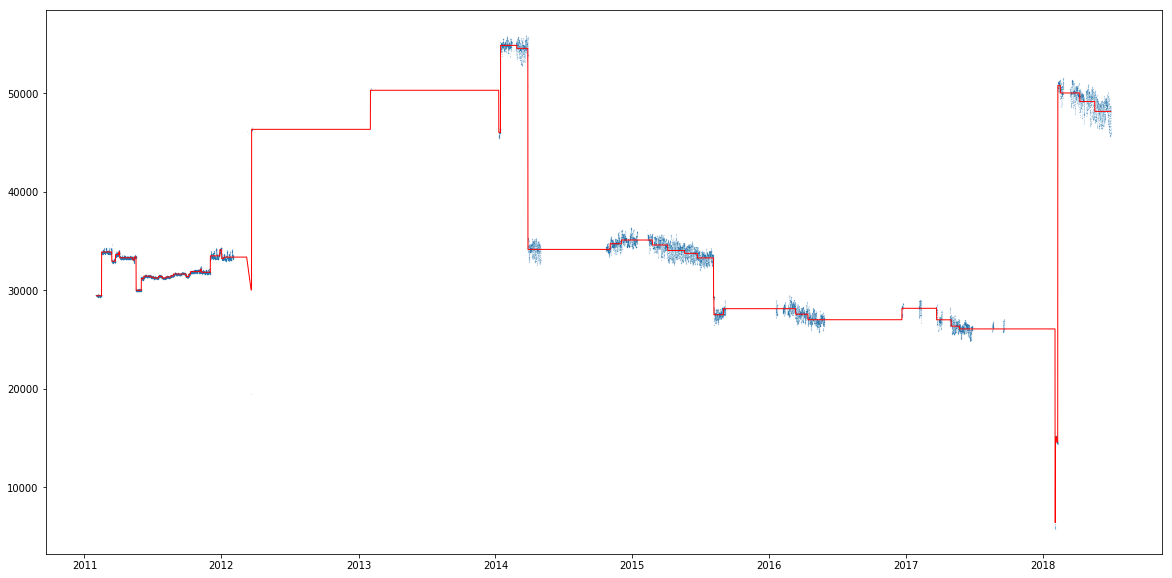

In [6]:
detector = cpDetector([mag_dat_1h["reading"]], distribution='log_normal', log_odds_threshold=0)
detector.detect_cp()
plt.figure(figsize=(20,10))
mag_dat_1h["cps"] = detector.step_function['traj_%s' % 0]
plt.plot(mag_dat_1h["reading"], 'o', alpha=0.6, ms=0.1)
plt.plot(mag_dat_1h["cps"], 'r', linewidth=1)

#### Detecting time discontinuities.

If there is a significant gap in time in the data, it will be assumed that the data needs splitting at this point. This is considerably simpler to detect than step changes. Time discontinuities are found simply by "differencing" the times, and then selecting the most significant differences. For now, any time greater than 1 day is considered a significant discontinuity.

The step change times and the time discontinuities are then combined into one array, by a union (to remove duplicate times).

In [7]:
# Get the changepoint times.
cp_times = mag_dat_1h.index[detector.change_points["traj_0"].ts]
# set the minimum difference for a time discontinuity to be considered "significant". 
sig_diff = np.timedelta64(1, 'D')
# Select the times where there are significant discontinuities.
discs = all_mag_dat.dropna().index[np.append([False], np.diff(all_mag_dat.dropna().index) > sig_diff)]
# Combine the changepoint and discontinuity times using a union.
split_times = np.union1d(cp_times, discs)
# Sort the times.
split_times.sort()
# Append the very first time from all the magnetometer data and the very last time.
# This is so when performing calculations, the magnetometer data between the very
# start/ end and the first/ last changepoint/ discontinuity is included.
split_times = np.append([np.datetime64(all_mag_dat.index[0])], split_times)
split_times = np.append(split_times, [np.datetime64(all_mag_dat.index[-1])])
split_times

array(['2011-02-01T12:02:00.000000000', '2011-02-15T09:00:00.000000000',
       '2011-03-14T14:00:00.000000000', '2011-03-24T12:00:00.000000000',
       '2011-04-02T01:00:00.000000000', '2011-04-04T13:00:00.000000000',
       '2011-05-09T12:00:00.000000000', '2011-05-14T02:00:00.000000000',
       '2011-05-18T11:00:00.000000000', '2011-06-01T09:00:00.000000000',
       '2011-06-07T21:00:00.000000000', '2011-06-26T17:00:00.000000000',
       '2011-07-04T09:00:00.000000000', '2011-07-17T05:00:00.000000000',
       '2011-07-27T11:00:00.000000000', '2011-08-05T22:00:00.000000000',
       '2011-08-18T22:00:00.000000000', '2011-08-25T23:00:00.000000000',
       '2011-09-28T07:00:00.000000000', '2011-10-05T19:00:00.000000000',
       '2011-10-10T13:00:00.000000000', '2011-11-05T06:00:00.000000000',
       '2011-11-08T10:00:00.000000000', '2011-12-02T12:00:00.000000000',
       '2011-12-27T17:00:00.000000000', '2012-01-01T16:00:00.000000000',
       '2012-01-07T15:00:00.000000000', '2012-03-08

#### Plot the raw readings figure again, but this time with all the changepoints.

We can plot the data changepoint/ discontinuity intervals in different colours, to visualise where the changepoints are. This is done by looping through the changepoints, selecting data between current and "next" changepoint.

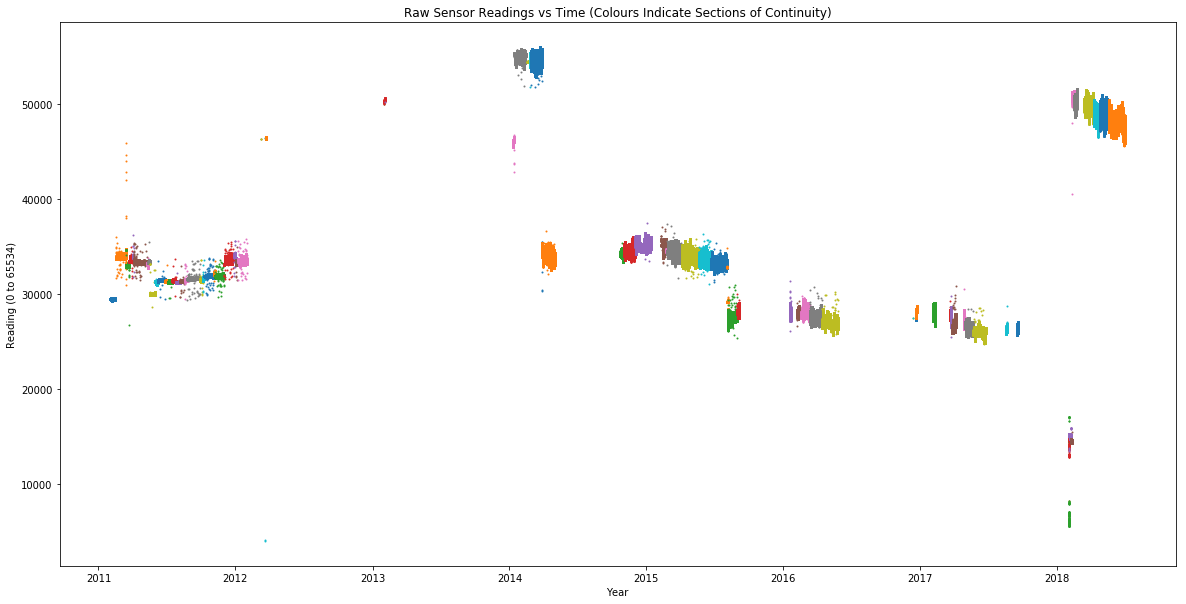

In [8]:
plt.figure(figsize=(20,10))
plt.title("Raw Sensor Readings vs Time (Colours Indicate Sections of Continuity)")
plt.xlabel("Year")
plt.ylabel("Reading (0 to 65534)")
# Create a counter for iterating through the times where the data gets split.
# Subtract 1 from the total number of times because the time after the current
# time selected by the counter will be selected each iteration. If the last
# time was reached, an "IndexError" would be thrown, because there's no
# element after the last.
for i in range(split_times.shape[0] - 1):
    mag_dat_win = all_mag_dat.loc[split_times[i]:split_times[i+1]]
    plt.plot(mag_dat_win["reading"], 'o', ms=1)

### 5. Calculating the magnetic field.

There are 4 processing steps needed to convert the raw sensor data into magnetic field data:
1. Convert the raw readings into a frequency*.
2. Correct the temperature.
3. Remove the temperature dependencies from readings.
4. Calculate the magnetic field variation from the data.

\*The first step will actually be to convert the raw data into a period, rather than a frequency. When the sensor reading is 0, the frequency is 120kHz and when the reading is 65534, the frequency is 50kHz.
Therefore, the simultaneous equations are:

$$ 50000(Hz) = m \times 65534 + c $$
$$ 120000(Hz) = m \times 0 + c = c $$

Solving these gives:

$$ Frequency (Hz) =  ( \frac{70}{65534} \times reading + 120 ) \times 1000 $$

The period is then simply the inverse of frequency. However, the equation we will use to convert frequency to period will include a bias, because this is required for converting period to teslas[1].
So, to get the period, we use[1]:

$$ period = \frac{1}{freqency + bias} $$

Finally, to convert this period into a frequency, we use Timur Zagidulin's equation. The equation is a simple polynomial[1]:

$$ magneticfield(nT) = \alpha + \beta \times period + \gamma \times period^{2} + \delta \times period^{3} + \epsilon  \times period^{4} + \zeta  \times period^{5} $$

In [9]:
# Set the bias.
bias = 90000
# Calculate the period, with the bias.
all_mag_dat["period"] = np.power(((-all_mag_dat["reading"]*70/65534+120)*1000+bias), -1)
# Create a place to store the "corrected" temperature.
all_mag_dat["temp_corr"] = all_mag_dat.loc[:, "temperature"]
# create places to store the period with the temperature correction and the magnetic field.
all_mag_dat["period_temp_corr"] = np.nan
all_mag_dat["mag_field"] = np.nan

Get the mean of all the coefficients from Timur's experiment and use these to calculate the magnetic field from our sensor. The function for calculating the magnetic field using the coefficients is also provided.

Set Timur's formula and coefficients:

In [10]:
# Coefficients for the formula to convert period to magnetic field, from [1].
coefs = np.vstack(([ 7.75627250e+06, -5.60893614e+06, 1.61438337e+06, -2.30773456e+05,
                    1.64006851e+04, -4.67419417e+02],
                     [ 1.37845775e+07, -1.08586181e+07, 3.43274556e+06, -5.43192224e+05,
                      4.30466903e+04, -1.37019412e+03],
                     [ 9.93009467e+06, -7.05978073e+06, 1.98324201e+06, -2.74458051e+05,
                      1.87117495e+04, -5.06023333e+02])).mean(axis=0)

# Set the formula:
def mag_field(period_dat, coefs=coefs):
    # 1e*6, because function expects microseconds.
    return np.polynomial.polynomial.polyval(period_dat*1e6, coefs)

#### Processing the raw data into magnetic field readings.

For some reason, the temperature readings "loop back" to $ 0^{\circ} C $ when the temperature exceeds about $ 30^{\circ} C $ (or the other way round, but it does not matter which way). This can be seen clearly in the figures generated 2 cells below. This looping can be detected using a Gaussian Mixture Model (an unsupervised, cluster classifier). Temperature and sensor readings are used as the inputs for this model. The data that is detected as having "looped" is coloured yellow, while (assumed) unaffected data is labelled as purple. Temperatures detected as having "looped" are corrected by adding the maximum temperature to them.

The next step is to remove the temperature dependency from the sensor readings. The sensor-temperature relationship is assumed to be exponential due to a bipolar transistor, or:

$$ period \propto A e ^{a \times temperature}$$

By fitting this function to the temperature and period, and subtracting this function from the period, the temperature dependency can be removed.

The magnetic field is then calculated as explained above. Also, the "average" magnetic field is subtracted to remove the measured absolute magnetic field, because this will not be correct. The actual absolute magnetic field can be obtained using the variational magnetic field plus the field calculated using the IGRF model.

In [11]:
### period-temperature dependency functions###
def exp_fun(x, A, a, c):
    return A*np.exp(a*x) + c
# Attach initial parameters to the functions, to help the function fitter.
exp_fun.init_params = {"A":1e-7, "a":-1e-2, "c":1e-6}

                       
def lin_fun(x, m, c):
    return x*m + c
               
lin_fun.init_params = {"m":-1, "c":1}

                       
def quad_fun(x, a, b, c):
    return a*x*x + b*x + c

quad_fun.init_params = {"a":-1, "b":-1, "c":1}
### period-temperature dependency functions###


def corr_temp(mag_dat):
    """
    Correct the temperature readings. This is done using a
    Gaussian Mixture model.
    
    Returns:
    - Pandas series with the corrected temperature.
    - A truth array which selects the temperatures
    which have been corrected.
    """
    X = np.column_stack((mag_dat["temperature"], mag_dat["period"]))
    gmm = mixture.GaussianMixture(n_components=2,
                                  covariance_type='full',
                                  means_init=((15, 0.000012), (0, 0.00001)),
                                 random_state=100).fit(X)

    temp_loopbacks = gmm.predict(X).astype(np.bool)
    mag_dat["temp_corr"] = mag_dat["temperature"]
    mag_dat.loc[temp_loopbacks, "temp_corr"] += mag_dat["temperature"].max()
    return mag_dat["temp_corr"], temp_loopbacks


def corr_period_temp_analysis(mag_dat, fun):
    """
    Fit a model of Period vs temperature.
    
    Returns:
    - A pandas series with corrected temperature.
    - A tuple of statistics representing how good the fit is,
    including reduced chi square, Akaike's information criterion
    and Bayesian information criterion; are also returned.
    - Parameters for the fitted function are returned.
    """
    # Set the model.
    temp_model = Model(fun)
    
    # 
    result = temp_model.fit(mag_dat["period"], x=mag_dat["temp_corr"], **fun.init_params)
    popt = [param.value for param in result.params.values()]
    
    temp_period_fit = fun(mag_dat["temp_corr"], *popt)
    mag_dat["period_temp_corr"] = mag_dat["period"] - temp_period_fit + mag_dat["period"].mean()
    return popt, (result.redchi, result.aic, result.bic), mag_dat["period_temp_corr"]


def plot_results(mag_dat, popt, temp_loopbacks, fun):
    """
    Plot the initial period vs temperature data, the corrected
    temperature data, and draw the fitted function relating
    period and temperature. The plots are also coloured, to
    indicate where the temperature is believed to have
    looped.
    """
    #setup plots.
    fig, ax = plt.subplots(1,2,figsize=(15,5))

    # Set the tick format to scientific.
    ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    ax[0].set_title("Period vs Temperature between\n"
                    + str(mag_dat.index.min()) + " and " + str(mag_dat.index.max()))
    ax[0].set_ylim((mag_dat["period"].min(), mag_dat["period"].max()))
    ax[0].set_ylabel("Period (s)")
    ax[0].set_xlabel("Temperature (C)")
    mag_dat_loop = mag_dat.loc[temp_loopbacks,["temperature", "period"]]
    mag_dat_nloop = mag_dat.loc[~temp_loopbacks,["temperature", "period"]]
    # Plot the period temperature data, with a legend.
    ax[0].scatter(mag_dat_nloop["temperature"], mag_dat_nloop["period"], s=1, label="temp")
    ax[0].scatter(mag_dat_loop["temperature"], mag_dat_loop["period"], s=1, label="looped temp")
    ax[0].legend(markerscale=6)

    # Similar to above, but now the corrected temperature is plotted.
    ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    ax[1].set_title("Period vs Corrected Temperature between\n" 
                    + str(mag_dat.index.min()) + " and " + str(mag_dat.index.max()))
    ax[1].set_ylim((mag_dat["period"].min(), mag_dat["period"].max()))
    ax[1].set_ylabel("Period (s)")
    ax[1].set_xlabel("Temperature (C)")
    mag_dat_loop = mag_dat.loc[temp_loopbacks,["temp_corr", "period"]]
    mag_dat_nloop = mag_dat.loc[~temp_loopbacks,["temp_corr", "period"]]
    ax[1].scatter(mag_dat_nloop["temp_corr"], mag_dat_nloop["period"], s=1, label="temp")
    ax[1].scatter(mag_dat_loop["temp_corr"], mag_dat_loop["period"], s=1, label="looped temp")

    mag_dat["temp_fit"] = fun(mag_dat["temp_corr"], *popt)
    mag_dat.sort_values("temp_corr", inplace=True)
    # Get the period-temperature fit curve.
    temp_period_fit = fun(mag_dat["temp_corr"], *popt)
    # Plot the fit.
    ax[1].plot(mag_dat["temp_corr"], mag_dat["temp_fit"], c="red", label="period v temp fit")
    ax[1].legend(markerscale=6)
    plt.show()
    
    mag_dat.drop("temp_fit", axis=1, inplace=True)
    
    
def get_mag_field(mag_dat, temp_fun=quad_fun, plots=True):
    """
    Get the magnetic field readings from raw sensor data.
    
    Returns:
    - Dataframe, with the magnetic field readings.
    - temperature fit statistics and parameters.
    """
    # Correct the temperature readings.
    mag_dat["temp_corr"], temp_loopbacks = corr_temp(mag_dat)
    # Get the temperature dependency on the magnetometer readings,
    # and the readings with the dependency removed.
    popt, f_stats, mag_dat["period_temp_corr"] = corr_period_temp_analysis(mag_dat, temp_fun)
    # Print the coefficients of the dependency
    print(popt)
    # Get the magnetic field readings (in nT).
    mag_dat["mag_field"] = mag_field(mag_dat["period_temp_corr"])
    # The absolute magnetic field is meaningless, so make sure absolute is removed from the variation.
    mag_dat["mag_field"] -= mag_dat["mag_field"].mean()
    
    if plots:
        # Plot the results.
        plot_results(mag_dat, popt, temp_loopbacks, temp_fun)
    
    return mag_dat, (*f_stats, *popt)

### Apply the conversion steps to each "window" between the discontinuities/ step changes in the data.

To try different temperature fitting functions, change the variable `temp_fun` below.

/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

[1.153001762790679e-10, -6.266121317610941e-09, 5.680231046425861e-06]


/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/ipykernel/__main__.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/ipykernel/__main__.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/ipykernel/__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

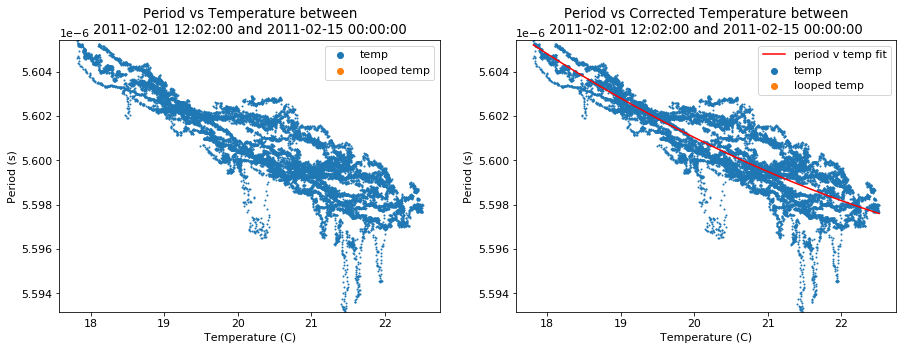

/home/james/anaconda3/envs/mag_srv_env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


[2.6126354640896544e-10, -1.3530222680451964e-08, 5.920243641627803e-06]


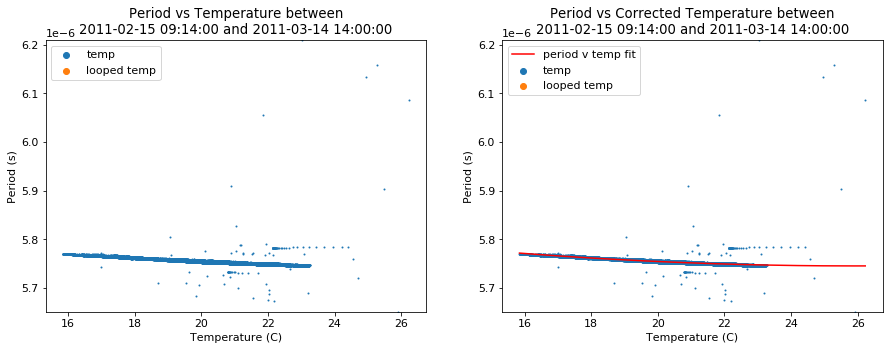

[3.4308832873378915e-11, -4.1371096811219884e-09, 5.793813723430106e-06]


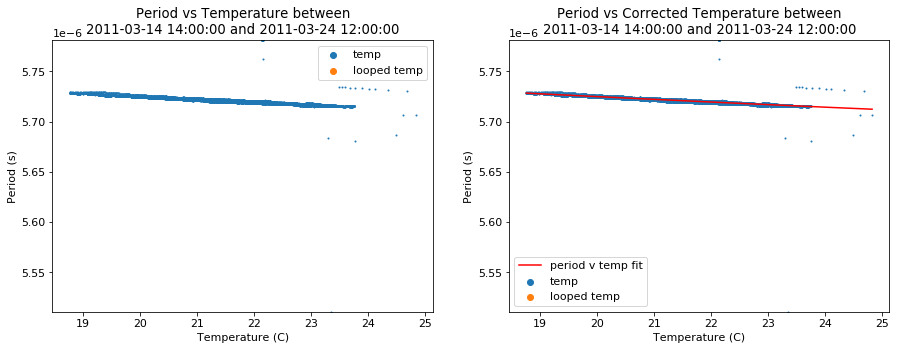

[1.593067396459618e-10, -9.640099330036193e-09, 5.879284518020266e-06]


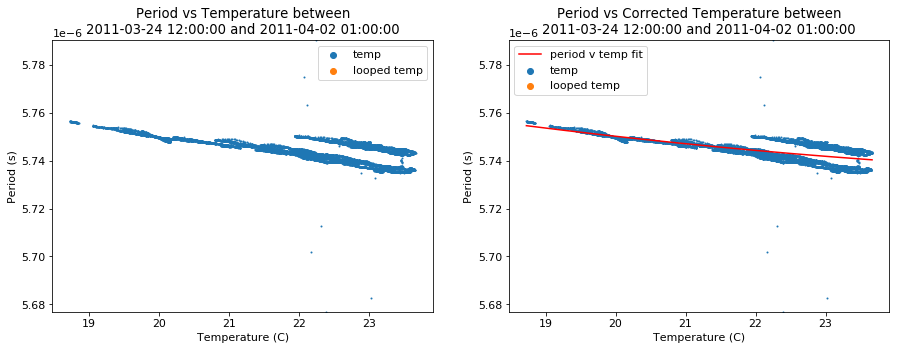

[7.280694685646763e-10, -3.4819124824241834e-08, 6.163733010070803e-06]


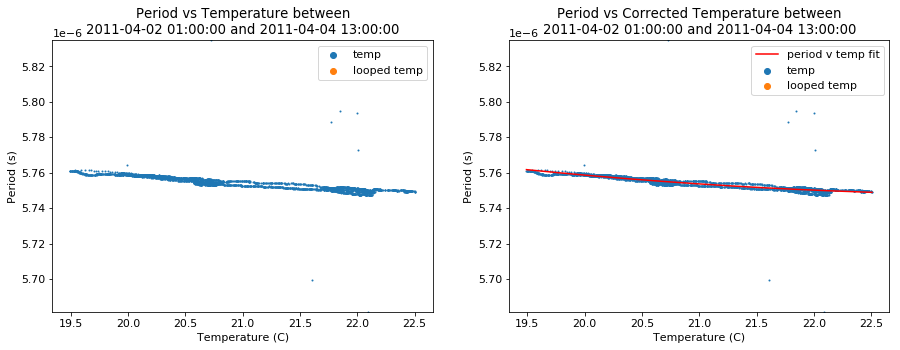

[-2.04245939950259e-11, -2.470926956506297e-09, 5.798380763099689e-06]


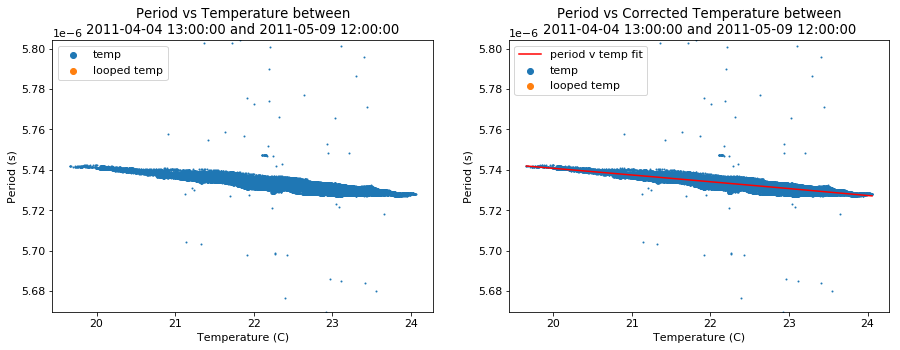

[-3.51864973430972e-09, 1.538620485929106e-07, 4.047678509275527e-06]


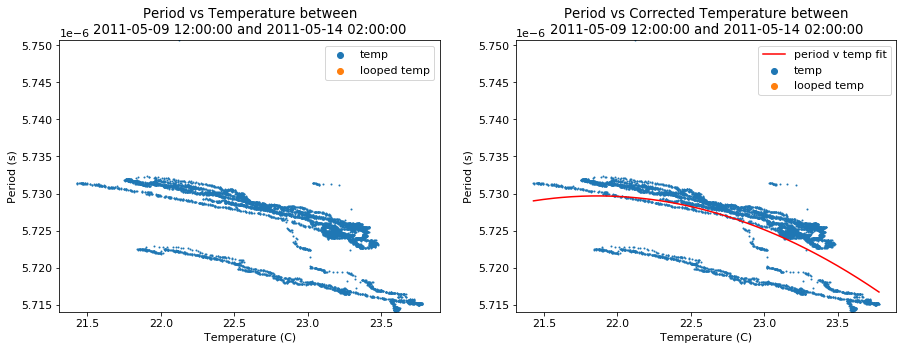

[1.5272647021334293e-09, -6.562192061861127e-08, 6.436979070197819e-06]


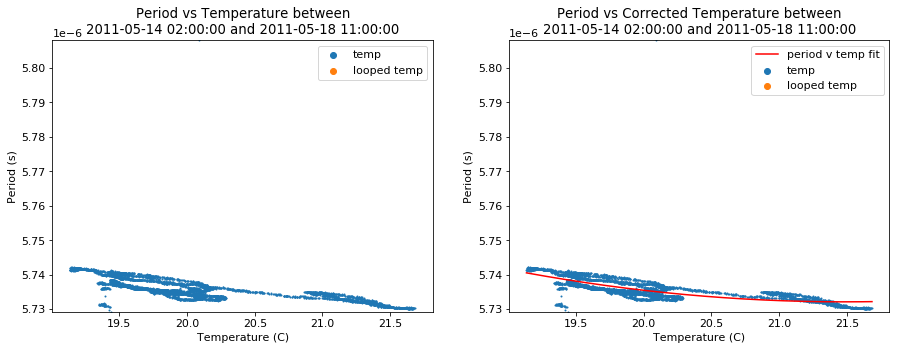

[3.730476185273003e-10, -1.7156787313391607e-08, 5.8103579983408865e-06]


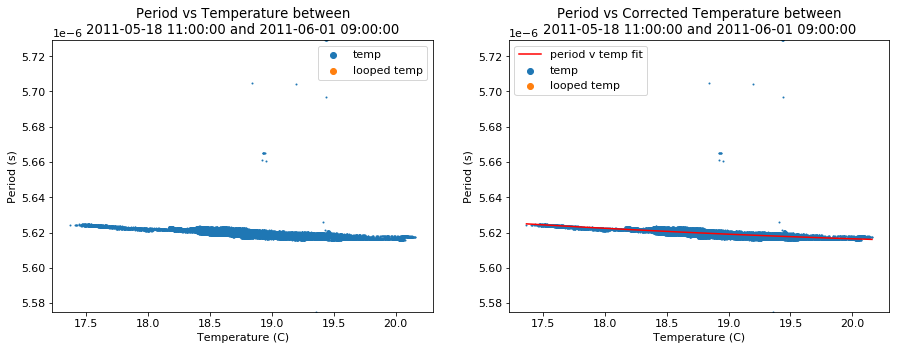

[-3.380992885276871e-10, 1.2357271284410785e-08, 5.551378866061779e-06]


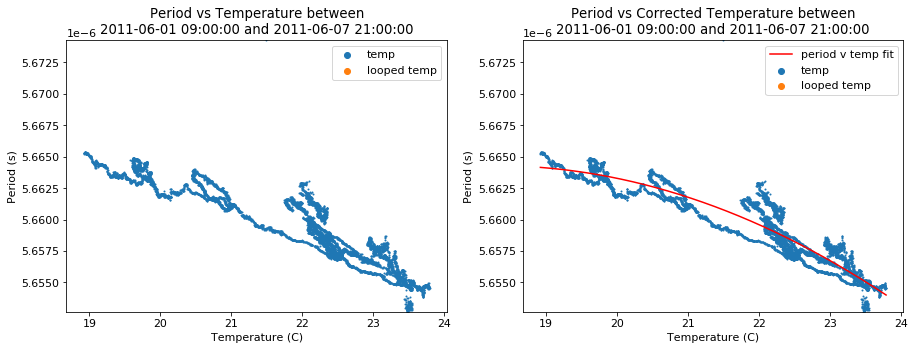

[-7.421144888337856e-11, -3.249265363477905e-10, 5.705152499519337e-06]


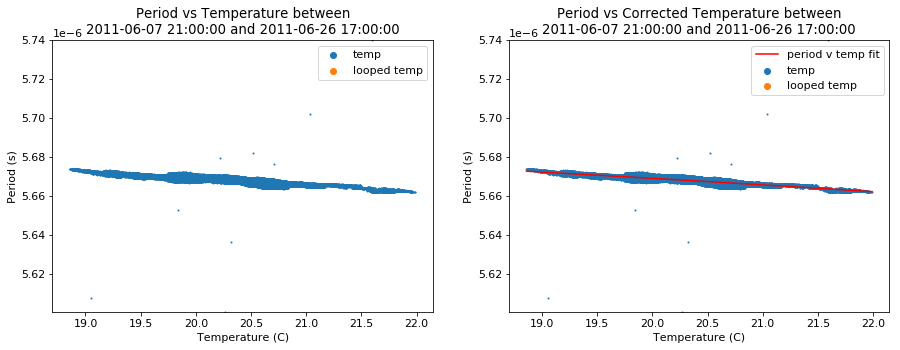

[1.669237009699472e-09, -7.662987318032047e-08, 6.5416765236706655e-06]


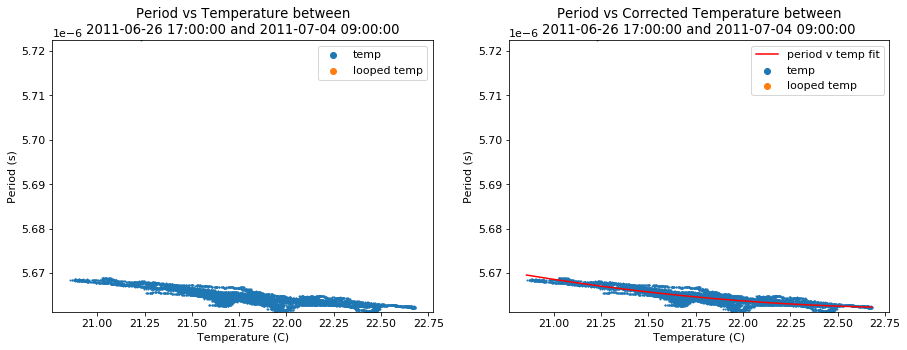

[6.951487238037242e-10, -3.462096121138817e-08, 6.0891163337083615e-06]


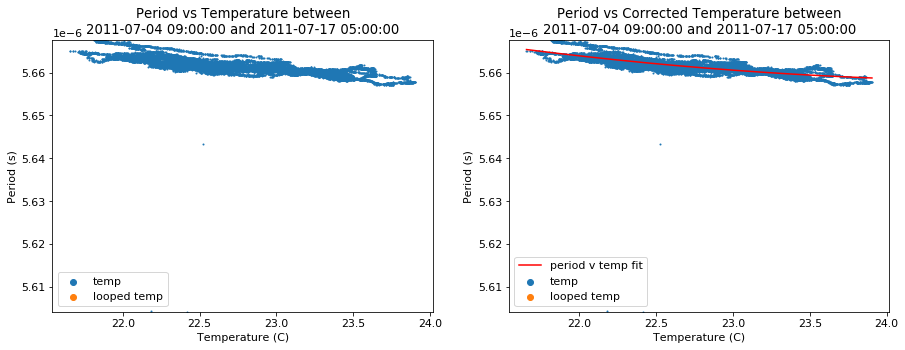

[3.787241355855687e-10, -1.9386695357975257e-08, 5.90699618444215e-06]


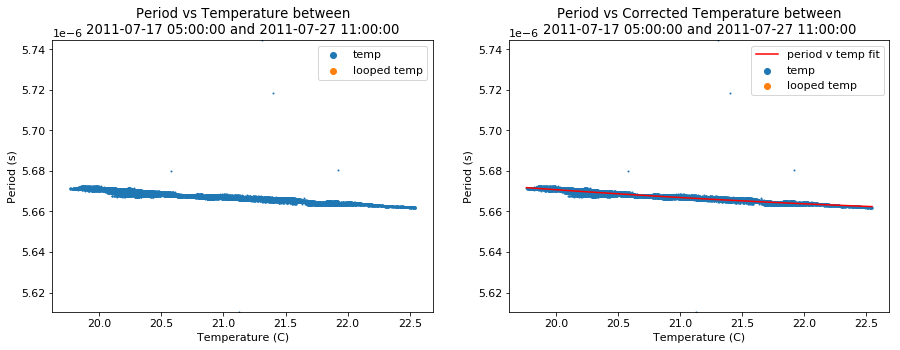

[7.543134236539991e-10, -3.7980726761104055e-08, 6.1355713598567714e-06]


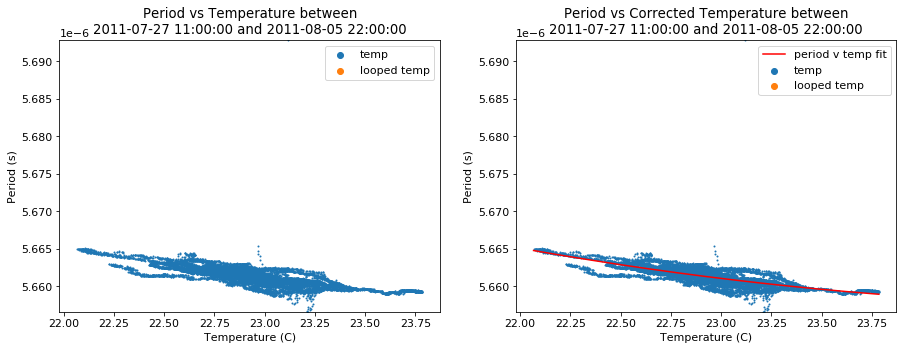

[1.1196526421103496e-09, -5.160722558435965e-08, 6.2577249433244795e-06]


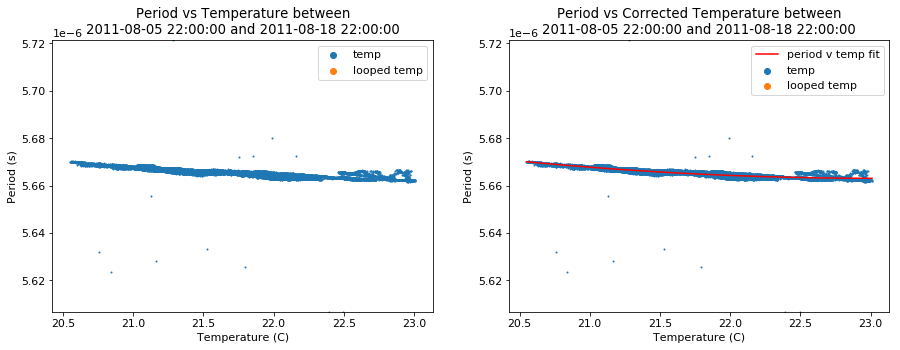

[-2.57228468765264e-09, 1.0950661806297006e-07, 4.5044941378440896e-06]


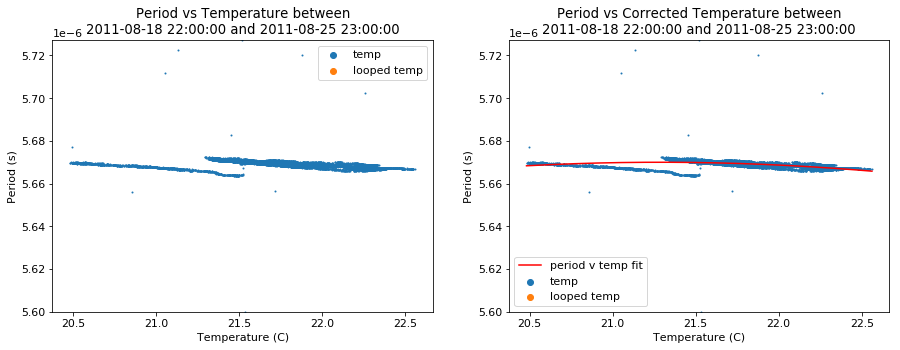

[9.341605438871296e-11, -6.96085116839594e-09, 5.777771391738867e-06]


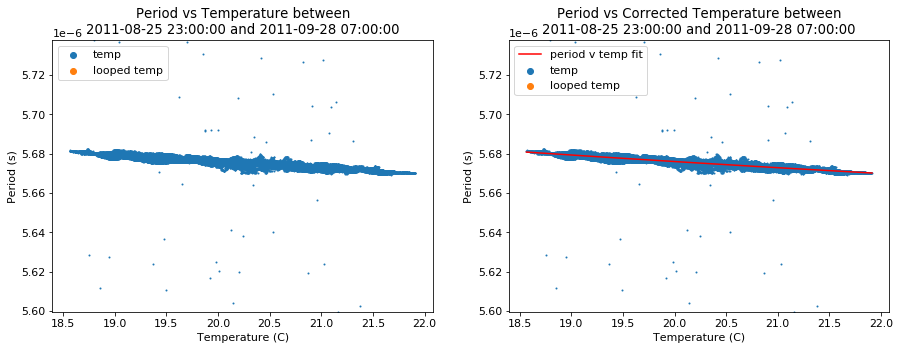

[-7.713122547270313e-11, 1.1542754204289123e-09, 5.6810868530531845e-06]


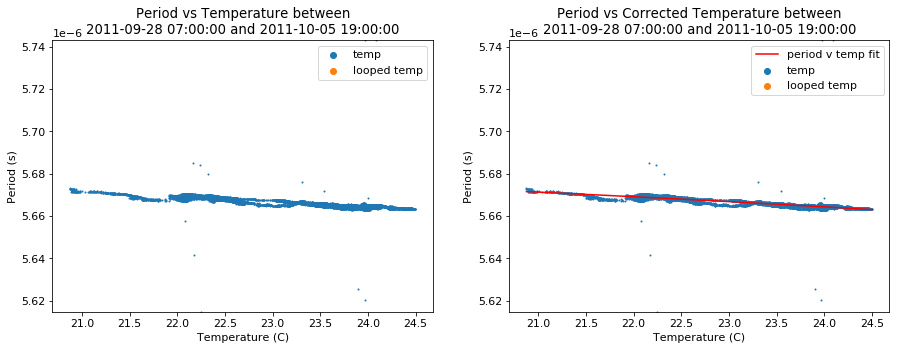

[-7.898841915558532e-11, -5.601893021566429e-10, 5.718663657866812e-06]


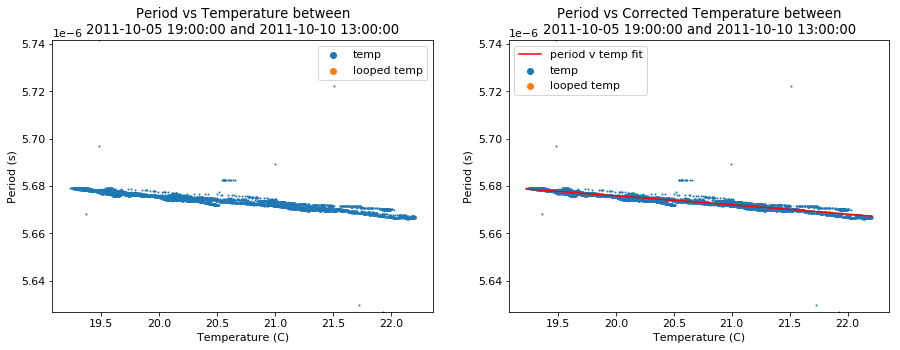

[-5.273234982051366e-11, -2.5886145525739905e-09, 5.761628624402626e-06]


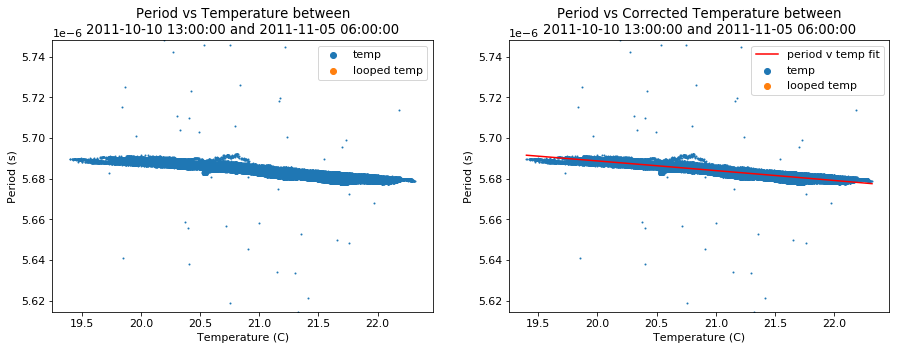

[-2.6773090401753335e-10, 4.920037088394849e-09, 5.692273585170962e-06]


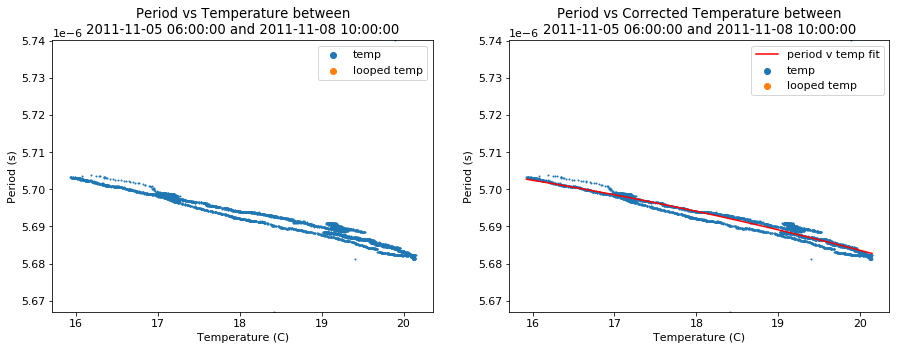

[-2.0273986648843723e-10, 4.1280672556403094e-09, 5.68226600477946e-06]


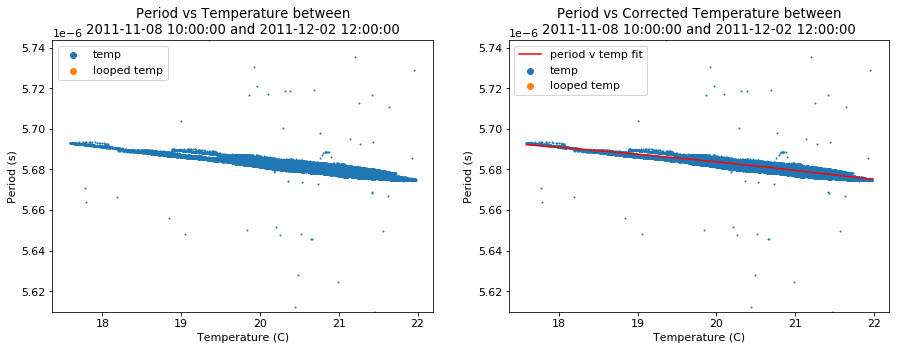

[1.9977219112838203e-10, -1.2669417687220602e-08, 5.905774848438513e-06]


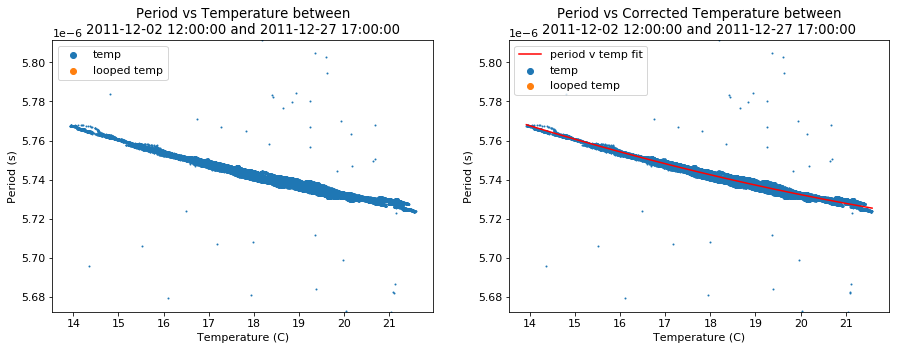

[7.234224183411672e-12, -6.2814656189104685e-09, 5.852532247175941e-06]


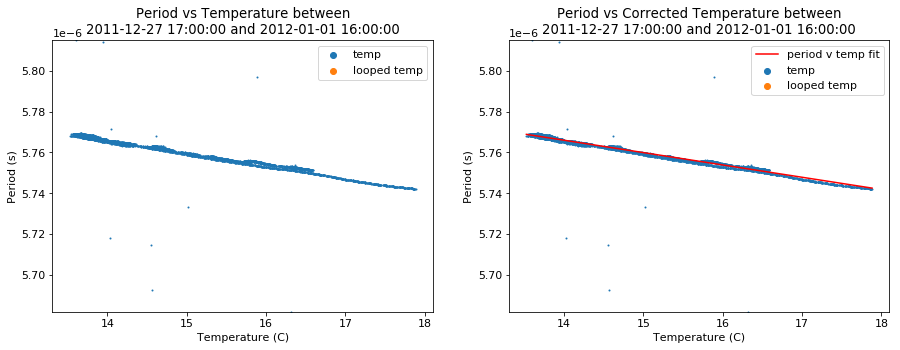

[-9.275985443599176e-11, -3.992157597971245e-10, 5.77842235016411e-06]


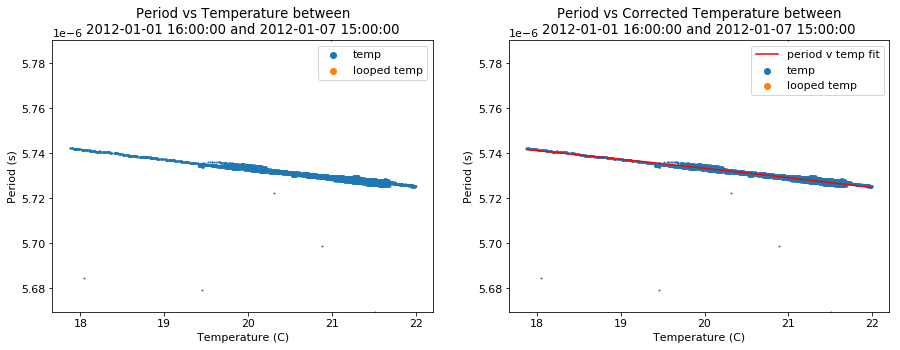

[1.4580056256887028e-10, -1.0848006756149823e-08, 5.892564486320965e-06]


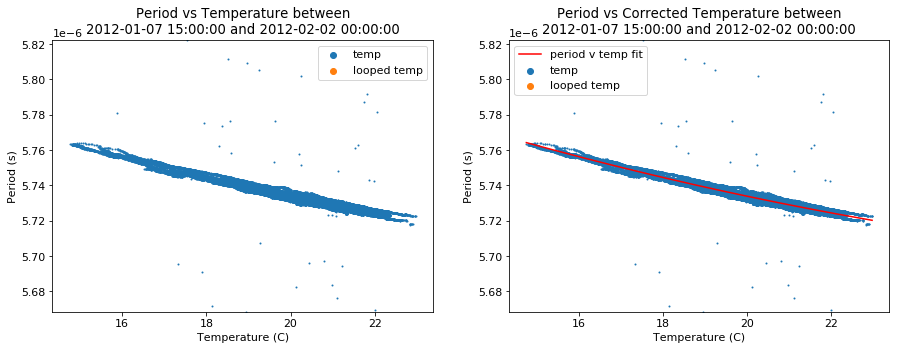

Expected n_samples >= n_components but got n_components = 2, n_samples = 1
[4.452486561664396e-08, -2.007414365625313e-06, 2.8851950919318354e-05]


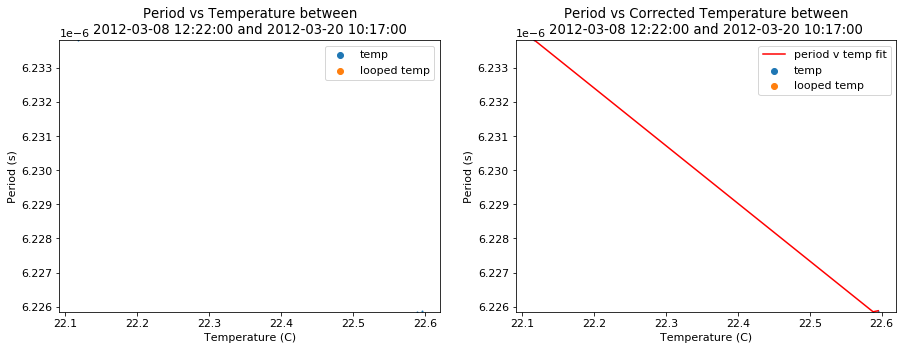

[1.6947994284903587e-08, -1.1925551503454928e-06, 2.5816125817092874e-05]


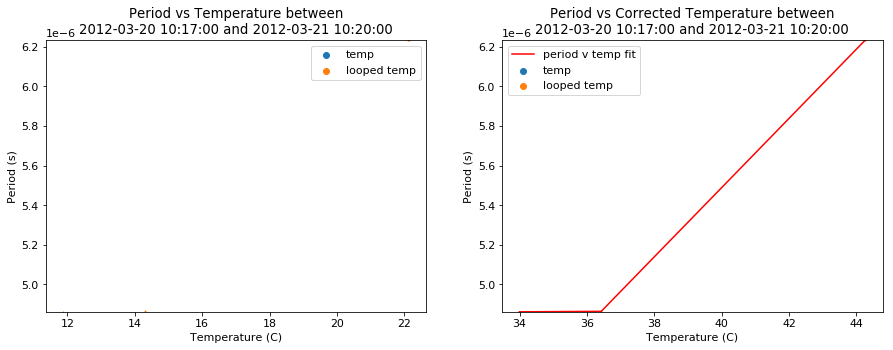

[-8.25410559204719e-09, 3.530296476790949e-07, 2.4618337288008458e-06]


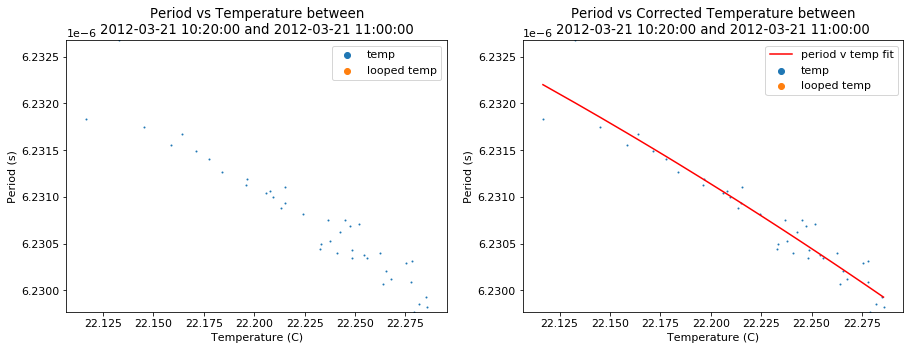

[-1.208788451351798e-09, 4.4035295281446604e-08, 5.8499426415622966e-06]


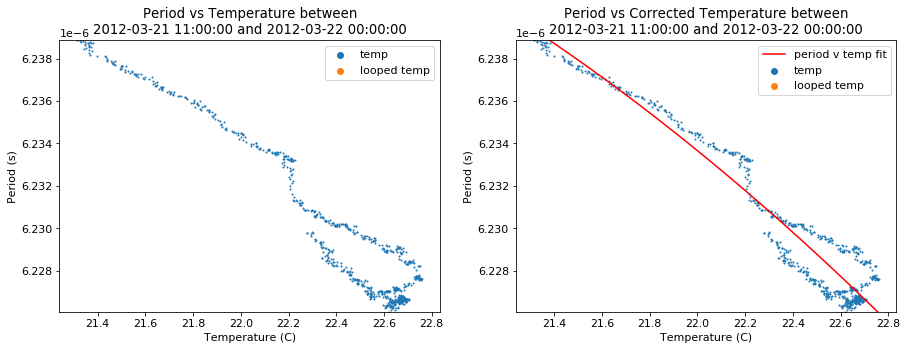

Expected n_samples >= n_components but got n_components = 2, n_samples = 1
[-1.2010127726278716e-09, 6.142150405992442e-08, 5.625480909374117e-06]


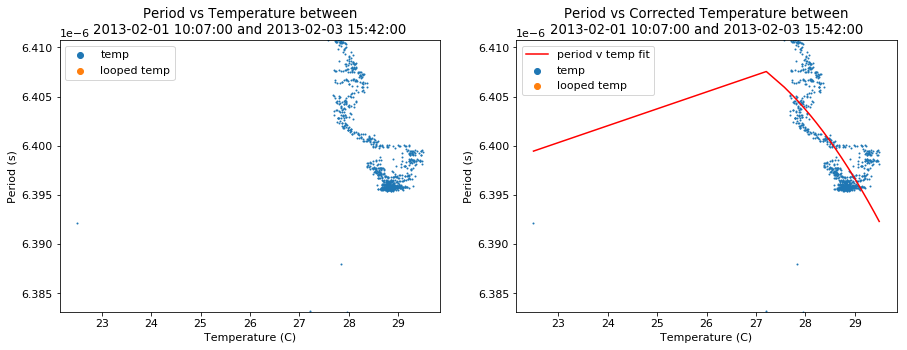

Expected n_samples >= n_components but got n_components = 2, n_samples = 1
Expected n_samples >= n_components but got n_components = 2, n_samples = 1
[-2.2374504794736217e-10, 5.124300079960838e-09, 6.232887127639448e-06]


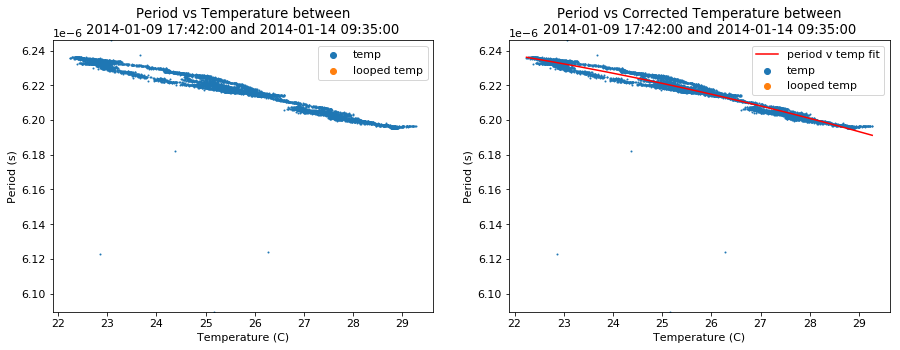

[1.406081764579465e-10, -1.3276109679331163e-08, 6.762611768666782e-06]


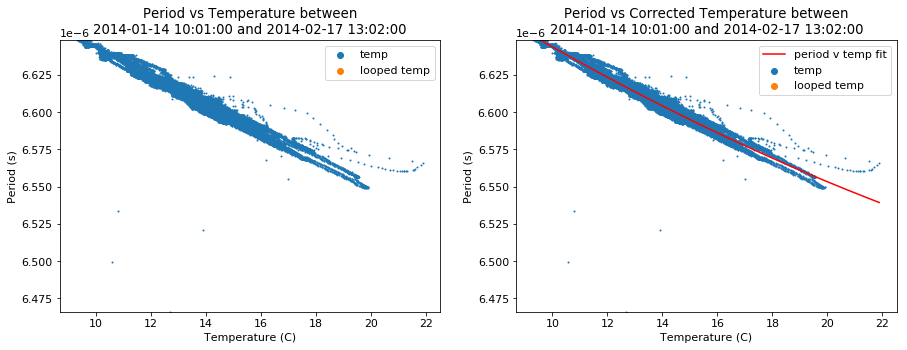

[2.940726016072866e-09, -9.984904380793186e-08, 7.425630573960998e-06]


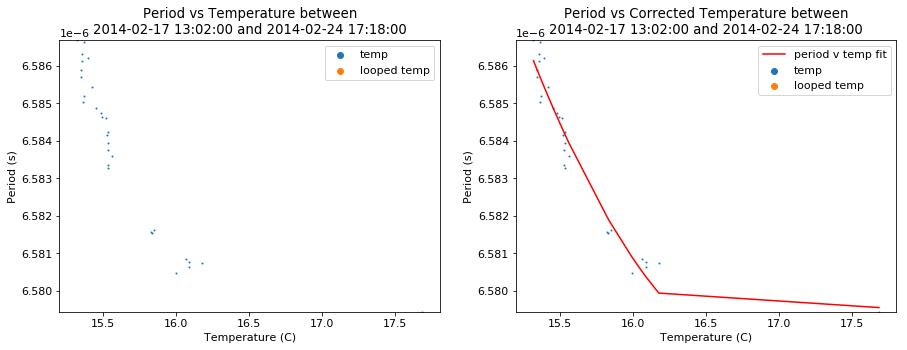

[5.083694538734158e-10, -2.7568789785562286e-08, 6.900990592789097e-06]


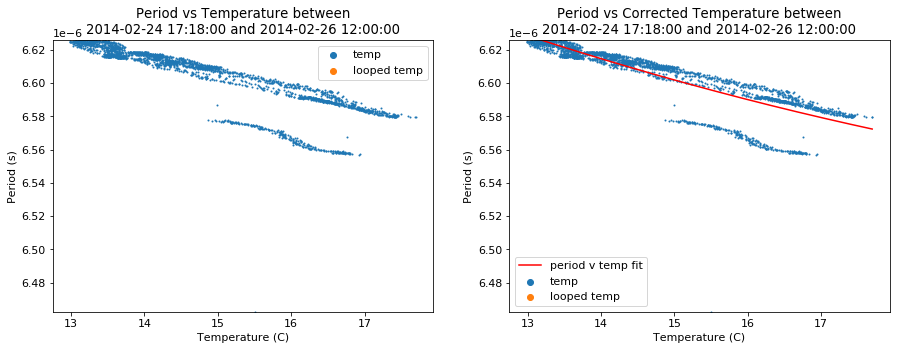

[1.4983803445334503e-10, -1.4616696181661006e-08, 6.7932243994461404e-06]


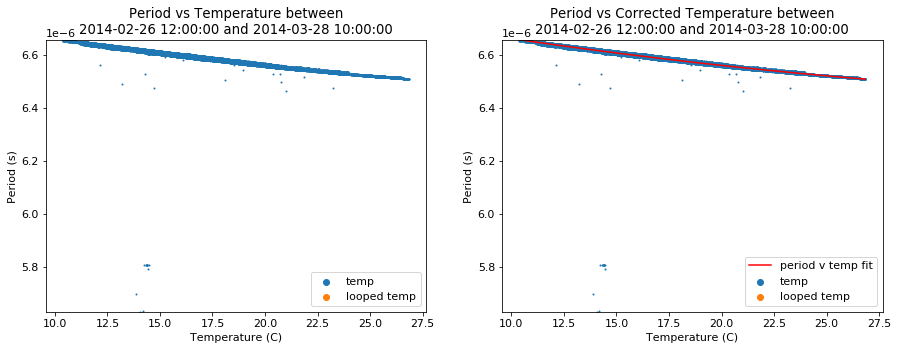

[7.957576330104066e-11, -8.958058963086953e-09, 5.915947668949467e-06]


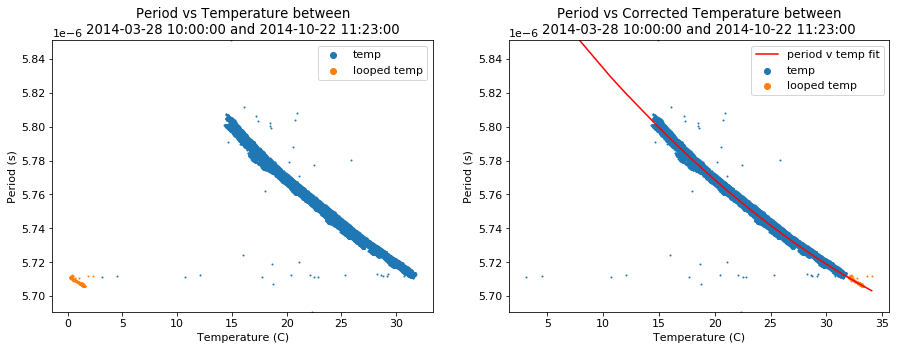

[1.438681172688166e-10, -1.2117960209146757e-08, 5.965713075932925e-06]


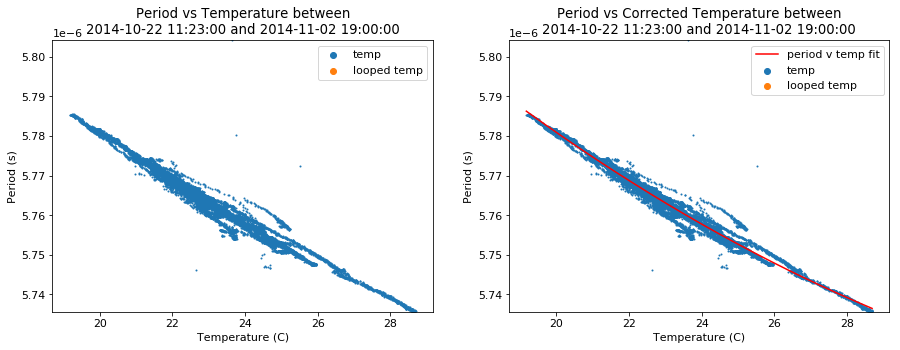

[8.04749548790157e-11, -9.113935219971525e-09, 5.928121166685202e-06]


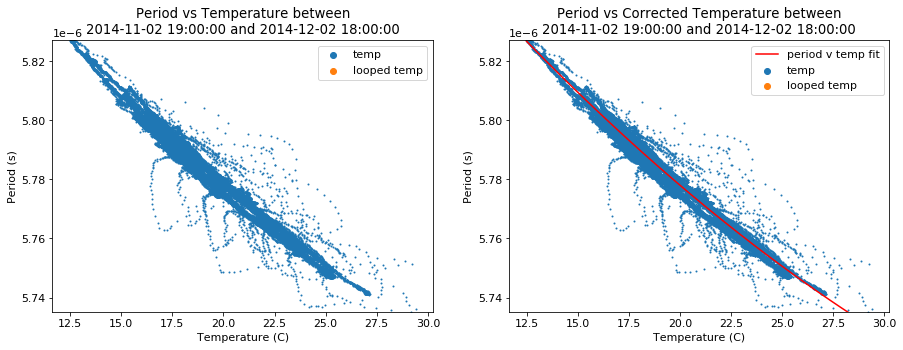

[1.5096127652449967e-10, -1.1626614346634664e-08, 5.945619105022466e-06]


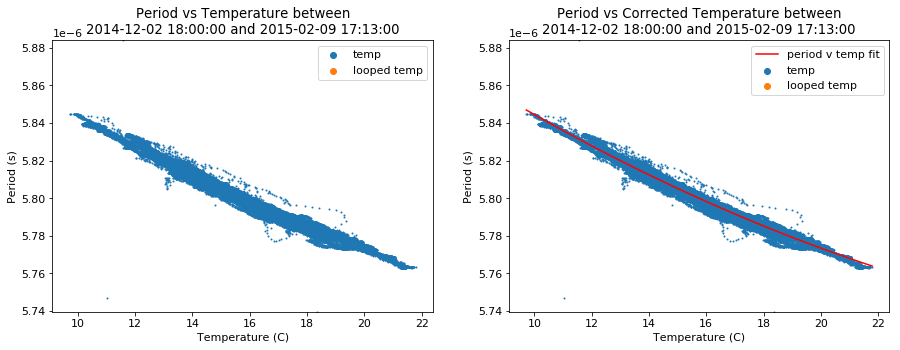

[1.0681046517303782e-10, -9.851110685646235e-09, 5.918722197087055e-06]


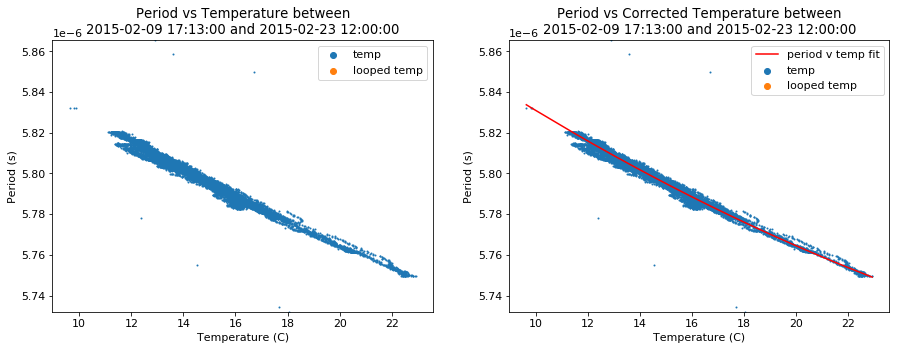

[-8.018564286497708e-10, 2.178593186735291e-08, 5.643794990507896e-06]


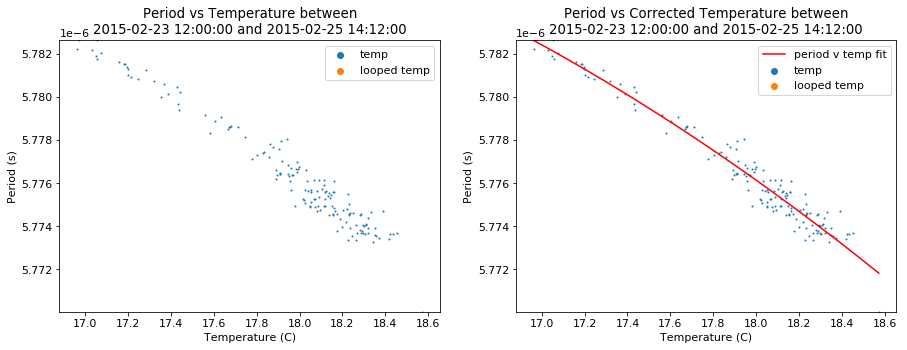

[1.2373011460566722e-10, -1.0389178941694516e-08, 5.918650417297669e-06]


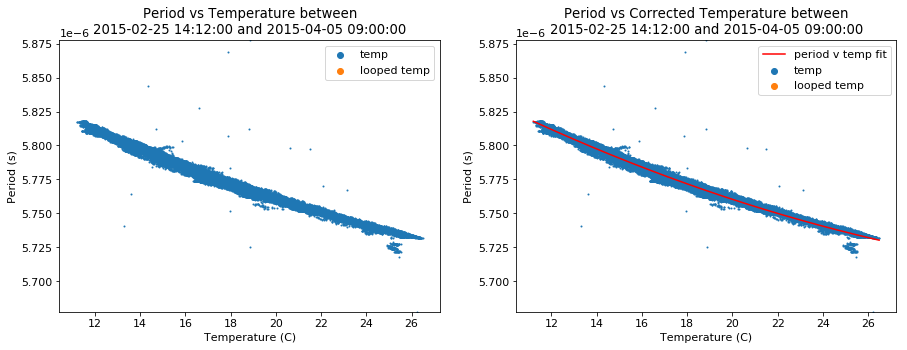

[6.90018309330787e-11, -8.056178532186394e-09, 5.901815585135212e-06]


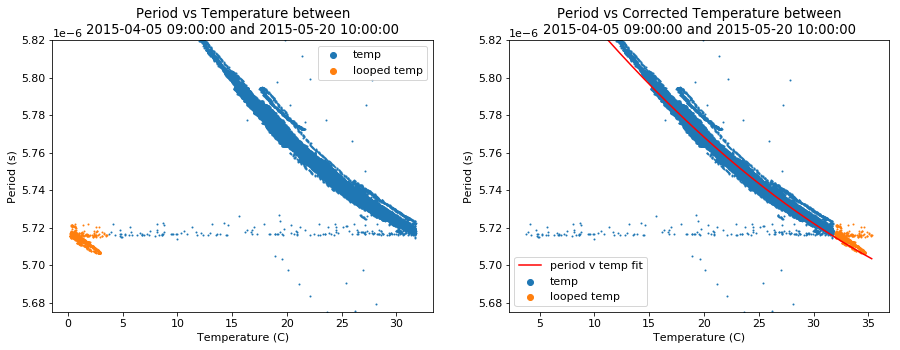

[-6.969533405002454e-13, -4.388704835538826e-09, 5.8572372069077e-06]


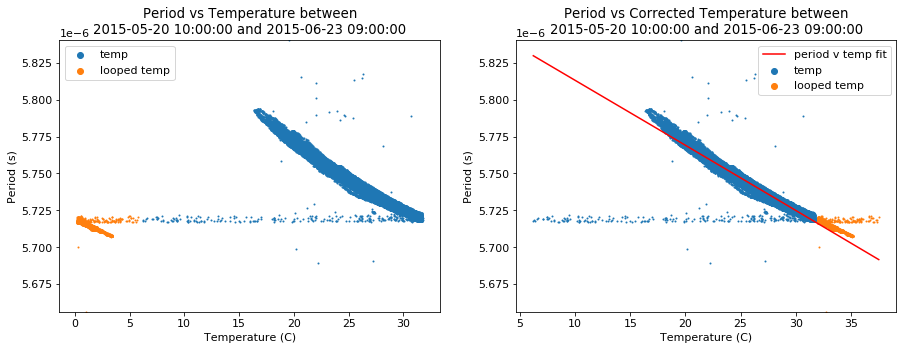

[-1.6470439370139016e-11, -2.798990321443935e-09, 5.8194534435339e-06]


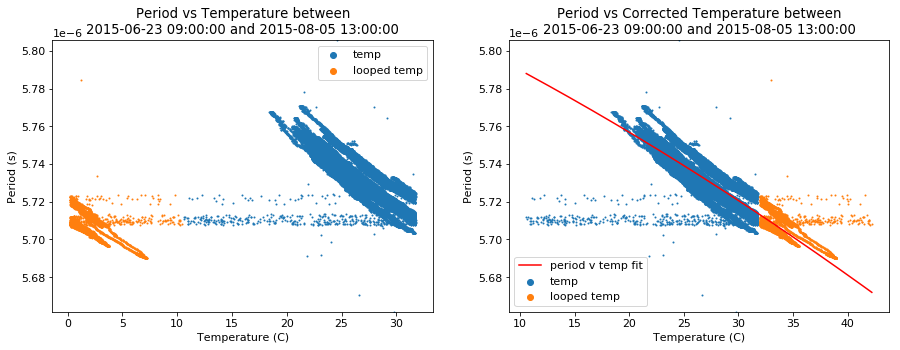

[1.500332481814782e-08, -7.444103090814396e-07, 1.4817820227103815e-05]


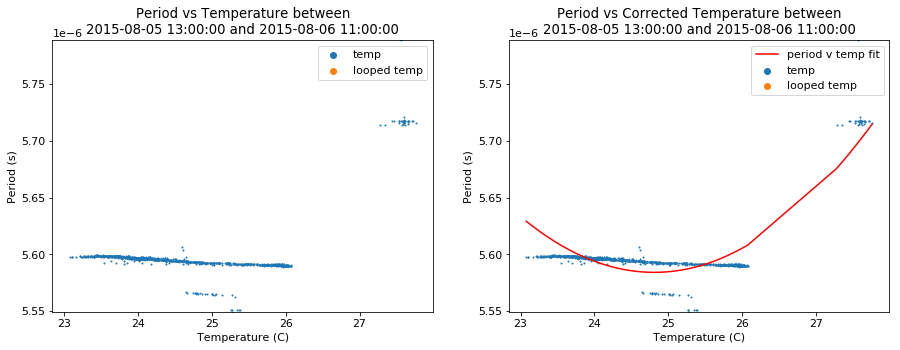

[1.8224524090480706e-11, -3.832088626220447e-09, 5.625634136217561e-06]


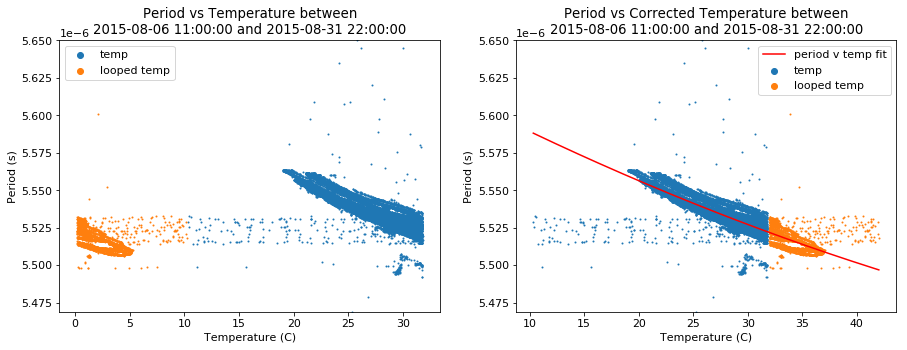

[2.0082271951949006e-10, -1.305731112518269e-08, 5.747506806106055e-06]


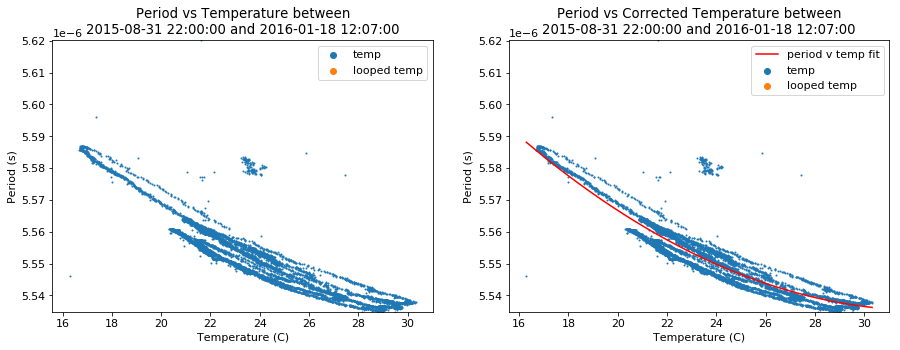

[2.1868496698018364e-10, -1.1547671960894611e-08, 5.6759479223446096e-06]


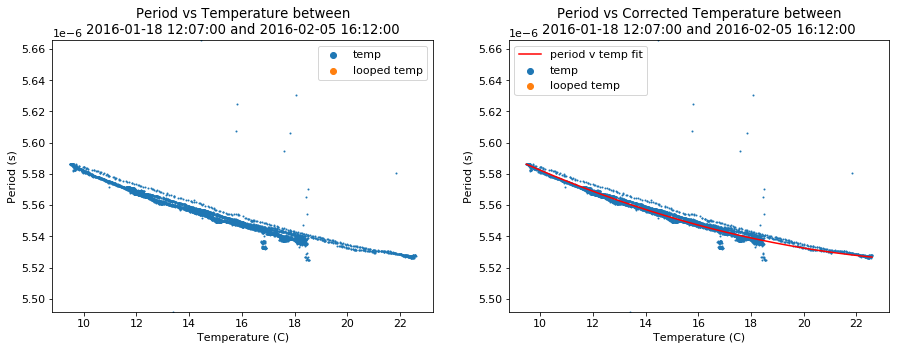

[3.477072489141856e-11, -6.216798672414749e-09, 5.638668929334968e-06]


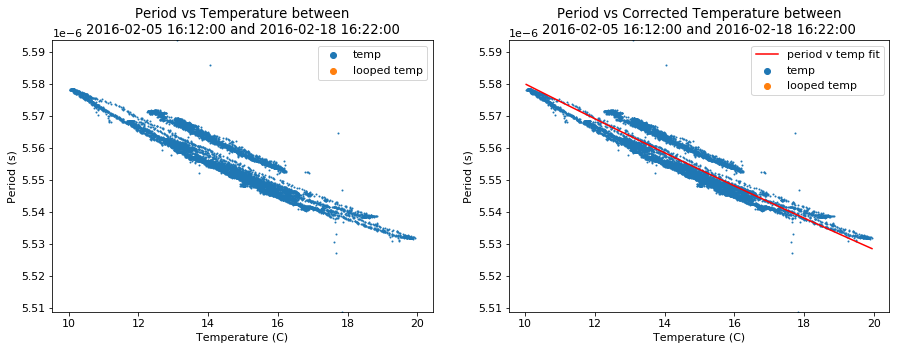

[2.2053021573209022e-10, -1.1789016745721944e-08, 5.682662461162919e-06]


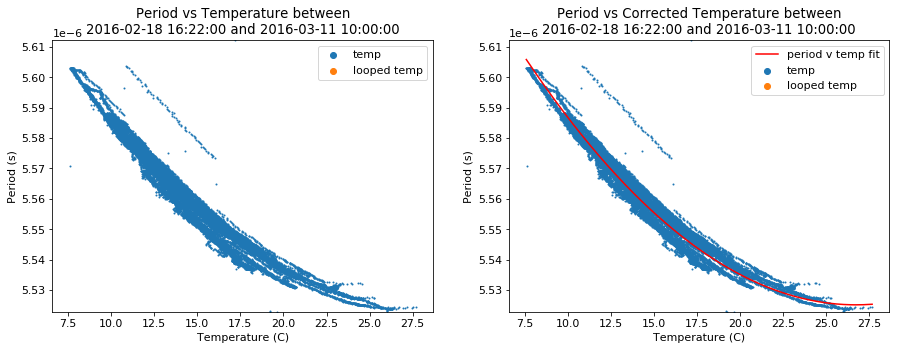

[1.584439802209449e-10, -9.926029688958067e-09, 5.665798300802347e-06]


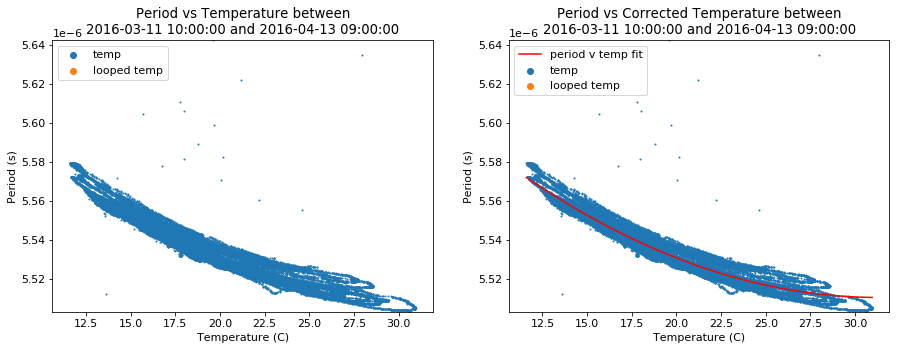

[4.9498926815394404e-11, -5.268433162834923e-09, 5.6139296074939905e-06]


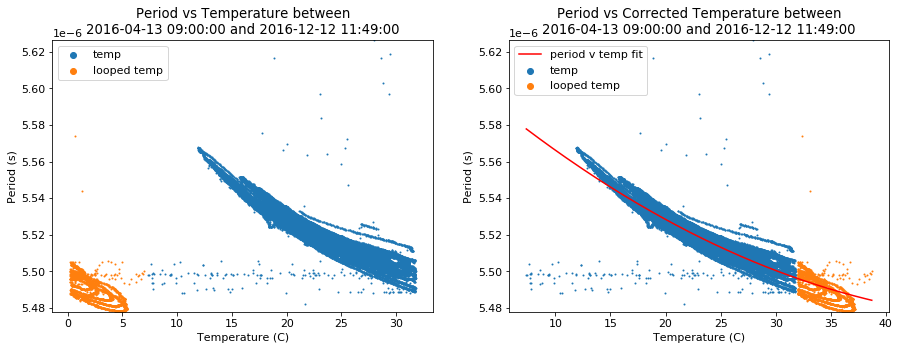

Improper input: N=3 must not exceed M=2
[1.2124589408610247e-09, -5.0965342344648584e-08, 6.0626994050819494e-06]


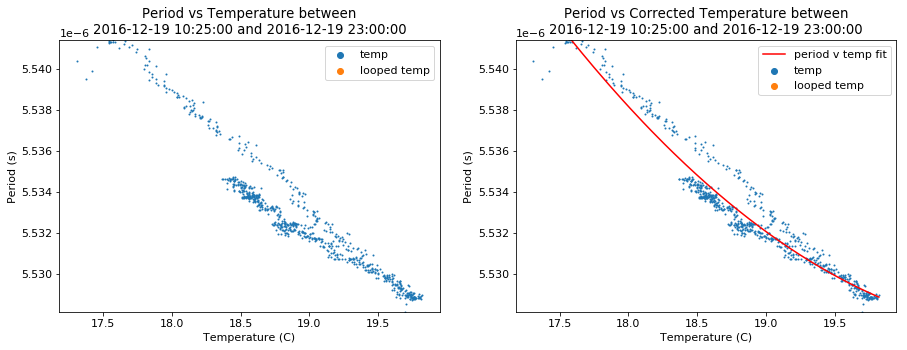

[-6.114545484998321e-10, 1.096624359965894e-08, 5.538464543537506e-06]


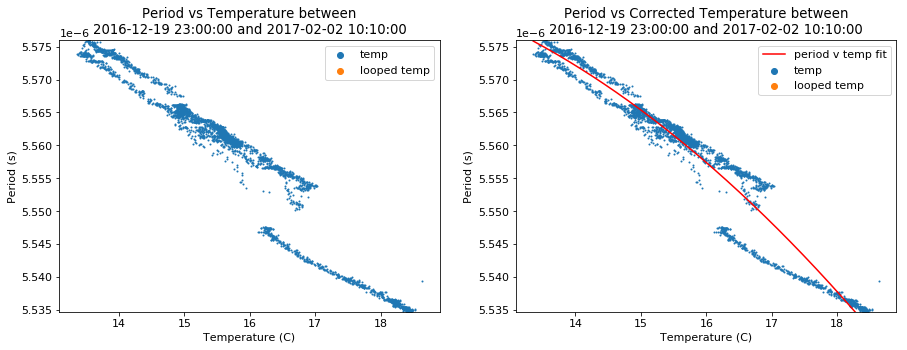

[1.641530493296208e-10, -1.123965330903099e-08, 5.691939350182953e-06]


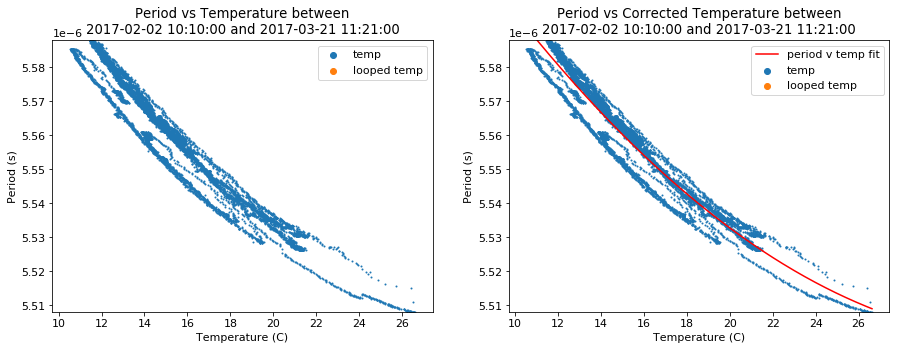

[2.148264059194426e-10, -1.2687960290101225e-08, 5.69346406609539e-06]


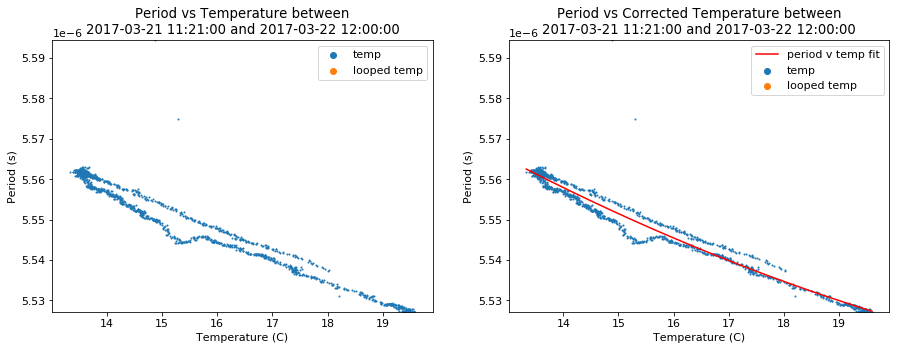

[2.179821861887658e-10, -1.3155107850909553e-08, 5.6978860861504295e-06]


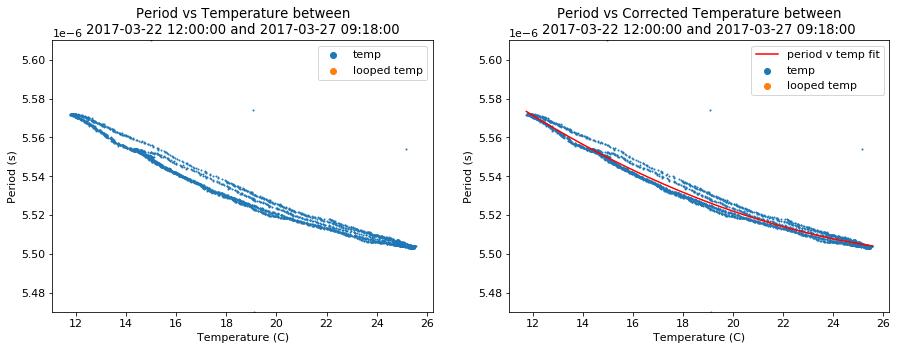

[4.96133605172506e-11, -5.771739961906925e-09, 5.618045906193273e-06]


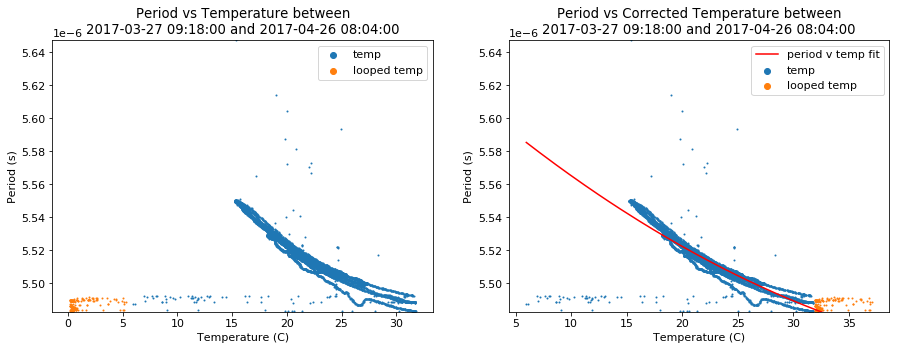

[2.2945623630625075e-10, -1.394022559242125e-08, 5.708114547920668e-06]


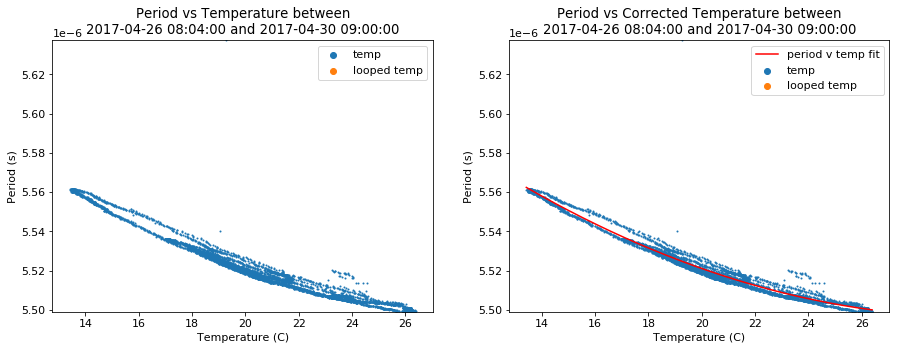

[6.989035593371343e-11, -6.742802433813882e-09, 5.624837376742419e-06]


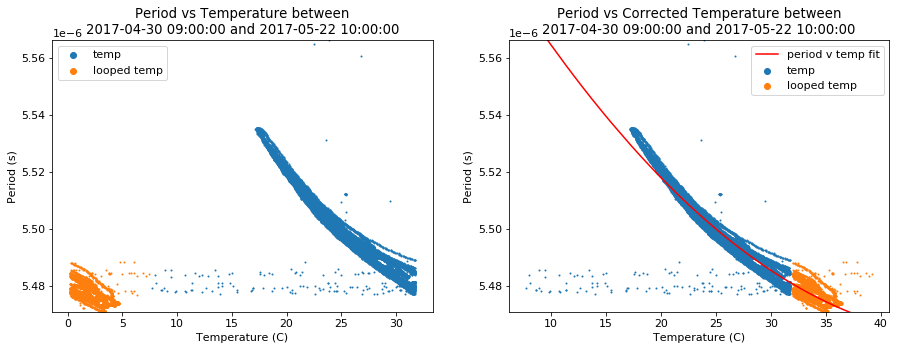

[3.059267402491846e-11, -4.683563402155884e-09, 5.595426836090661e-06]


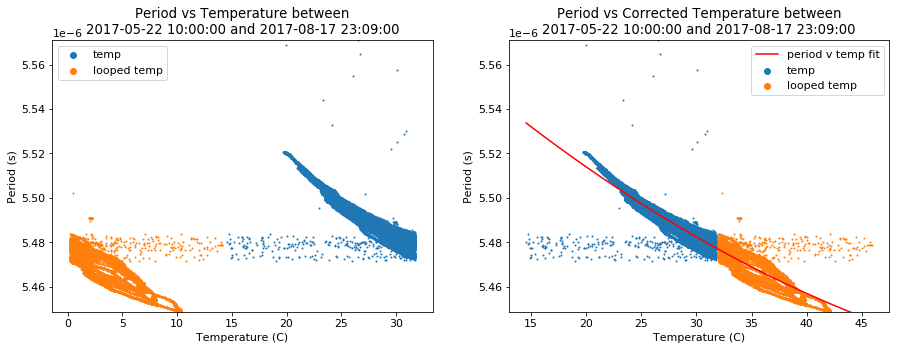

[1.8302360038586478e-10, -1.2701596477239173e-08, 5.6995946338648655e-06]


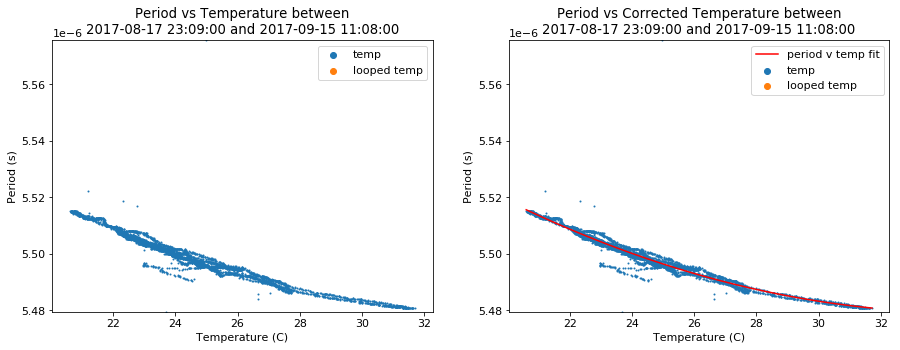

[2.1831638817453897e-10, -1.4269836944392308e-08, 5.711690309865286e-06]


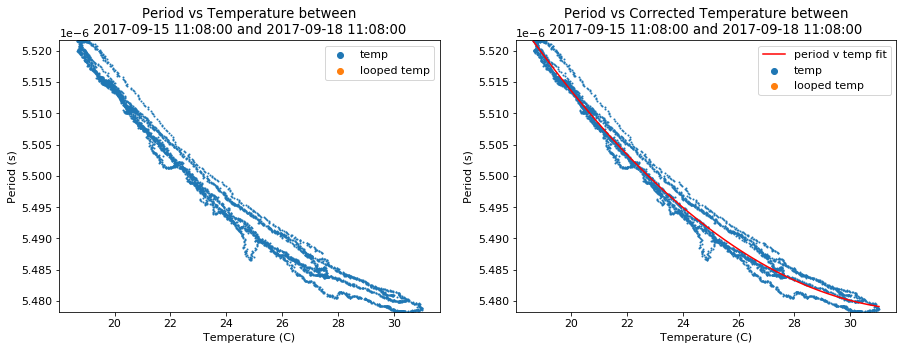

Expected n_samples >= n_components but got n_components = 2, n_samples = 1
[-8.13442949307998e-09, 4.93355314793454e-07, -2.5389997961091227e-06]


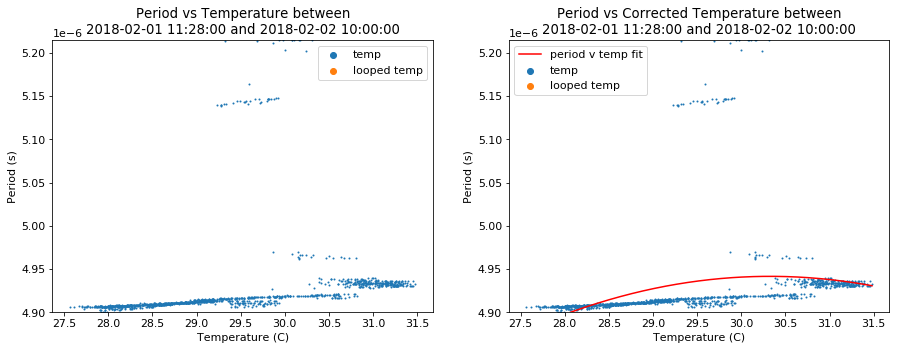

[3.0803720817374716e-10, -2.7973482393640523e-08, 5.698302072332122e-06]


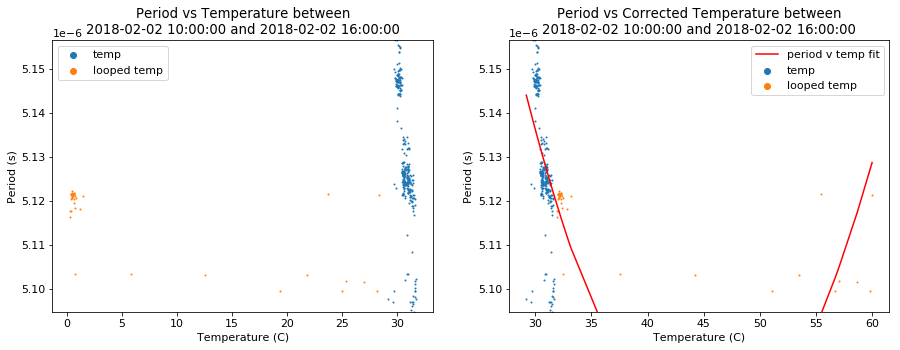

[3.646206883076626e-11, -1.1983821637638788e-09, 5.162112121042307e-06]


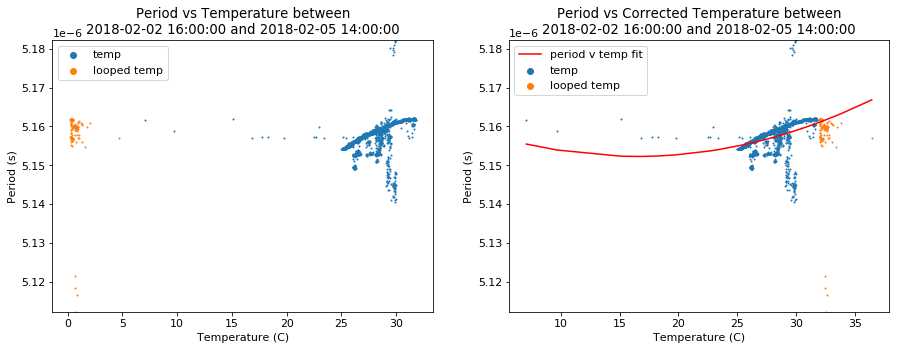

[-2.7109626787265524e-11, 2.683349803499482e-09, 5.088319534892564e-06]


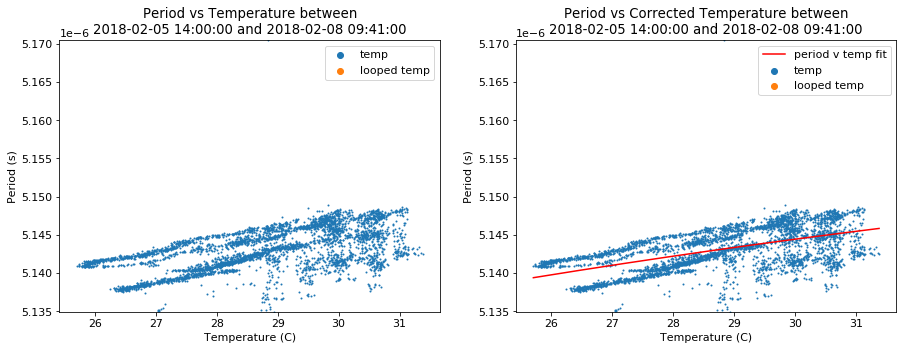

[-1.0077482547855771e-10, -4.011636347001842e-09, 6.497321170595346e-06]


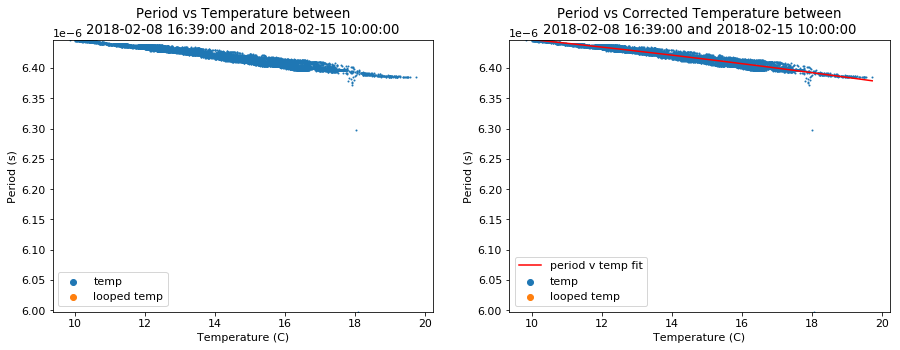

[4.56993395481774e-12, -7.698686228618963e-09, 6.521600453710151e-06]


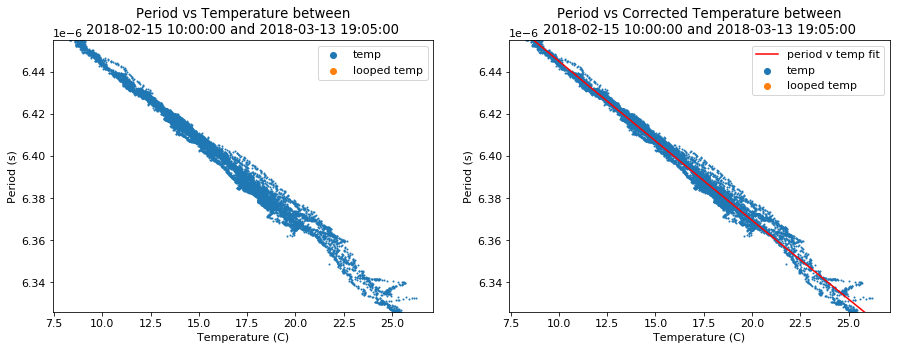

[-3.0681831511659826e-11, -6.56000588322079e-09, 6.514348096993954e-06]


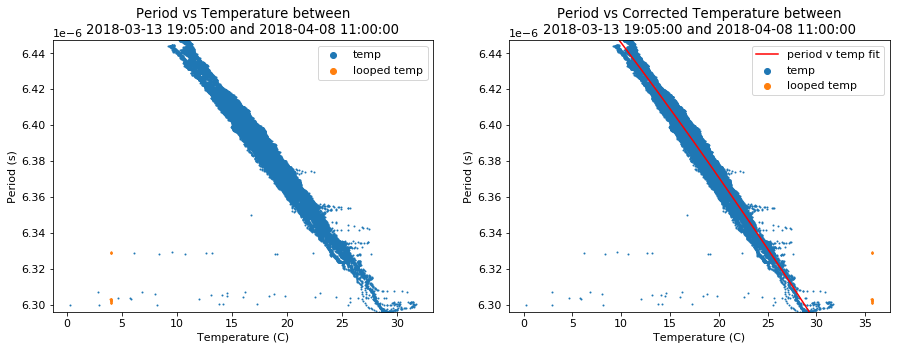

[-8.003367757174399e-11, -3.2972260374797187e-09, 6.468827936003501e-06]


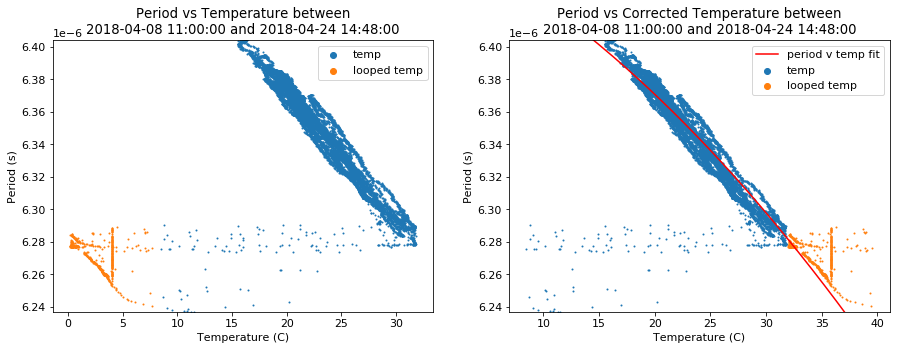

[-1.7489171596064397e-11, -7.08323077047249e-09, 6.527359669106094e-06]


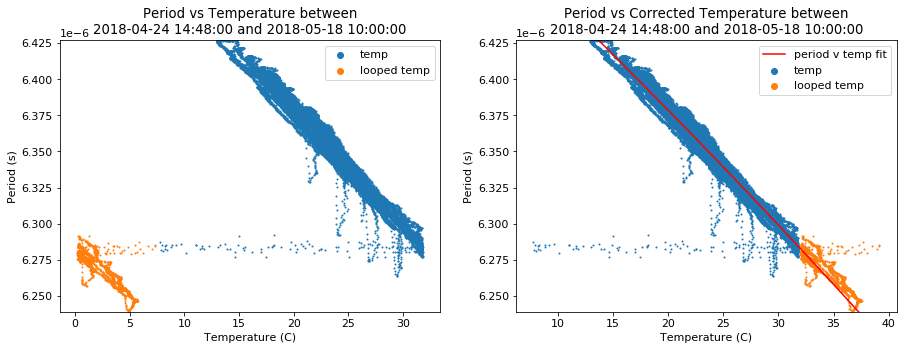

[1.5731322980967997e-10, -1.5548880352378518e-08, 6.631075257466994e-06]


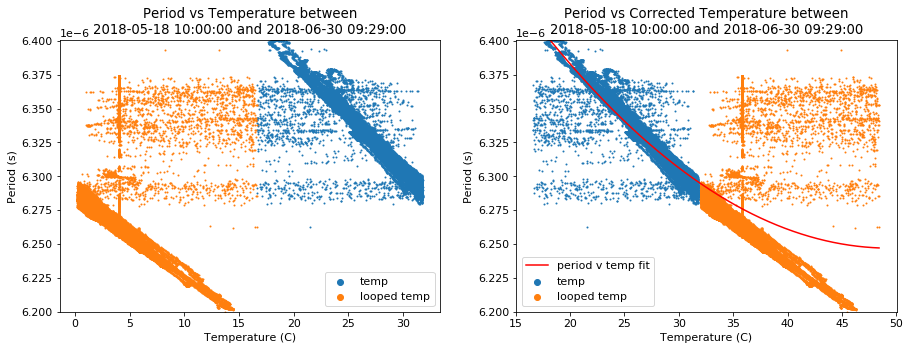

In [12]:
temp_fun=quad_fun # Other options: lin_fun, exp_fun.

# Create a dataframe to store all the period temperature function statistics.
func_summary = pd.DataFrame(columns=("rchi", "AIC", "BIC", *temp_fun.init_params.keys()))
# Temporarily change fontsize for these plots.
plt.rcParams.update({"font.size": 11})

# Iterate over the data splits.
for i in range(split_times.shape[0] - 1):
    try:
        # Get the new magnetometer data and the summary of the period temperature fit,
        # for this section of the data.
        all_mag_dat.loc[split_times[i]:split_times[i+1]], func_summary.loc[i] = get_mag_field(all_mag_dat.loc[split_times[i]:split_times[i+1]], temp_fun=temp_fun)   
    except (ValueError, TypeError, RuntimeError) as e:
        print(e)
        
        
plt.rcParams.update({"font.size": 22})

Print the average of summary of the period temperature fits.

In [13]:
func_summary.iloc[(func_summary == -np.inf) | (func_summary == np.inf)] = np.nan
print("Means of temperature fit statistics:\n", func_summary.mean())

Means of temperature fit statistics:
 rchi    5.106164e-17
AIC    -7.991306e+05
BIC    -7.991096e+05
a       8.582274e-10
b      -4.729380e-08
c       6.410289e-06
dtype: float64


#### Temperature plot after correction.

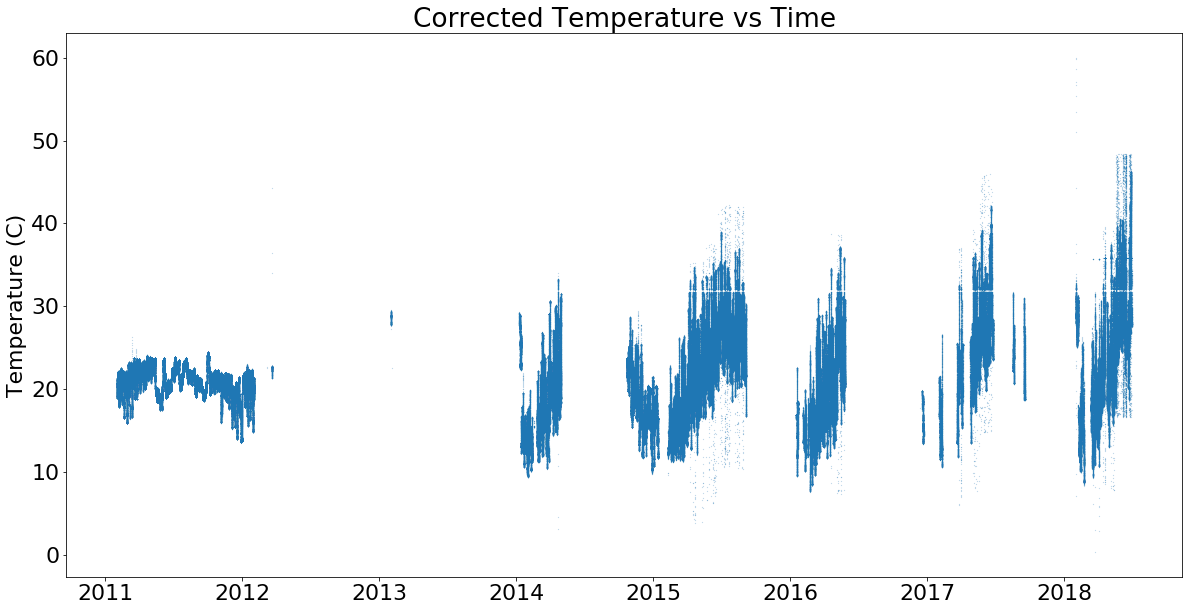

In [14]:
plt.figure(figsize=(20,10))
plt.title("Corrected Temperature vs Time")
plt.ylabel("Temperature (C)")
plt.plot(all_mag_dat["temp_corr"], 'o', ms=0.1)

### 6. Plot the variometer data.

Below, all the variameter data and the data for the 20/03/2016 is plotted. Note that erroneous values ($ \pm 1000nT+ $) are present. It may be worth considering removing these.

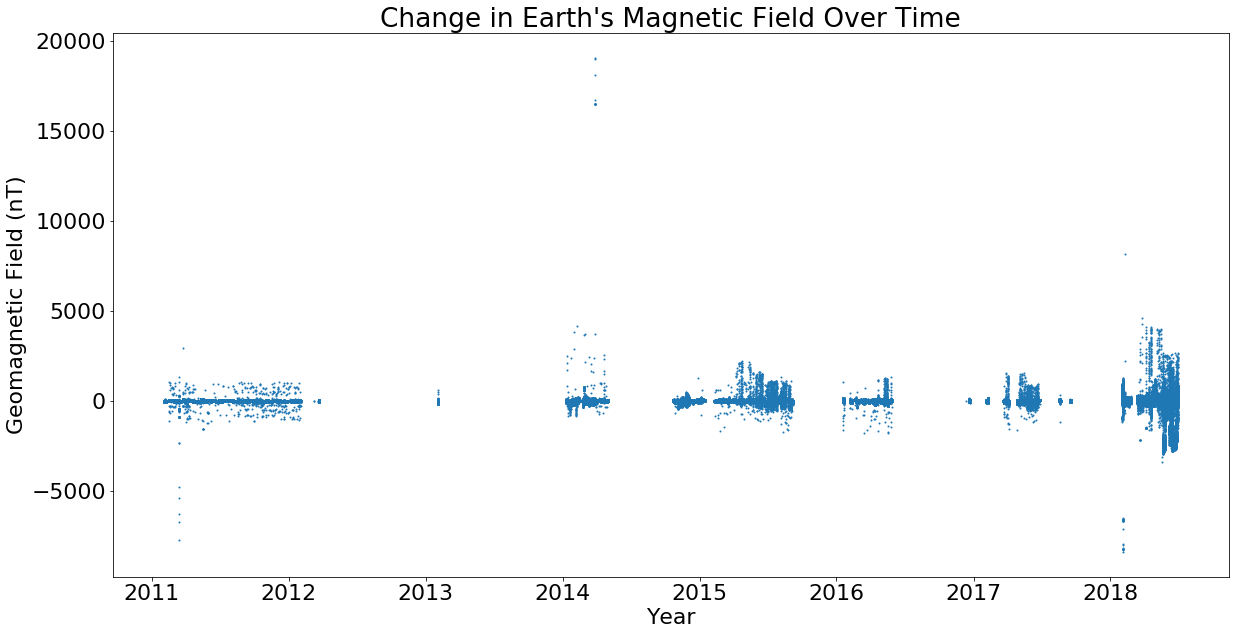

In [15]:
plt.figure(figsize=(20,10))
plt.title("Change in Earth's Magnetic Field Over Time")
plt.xlabel("Year")
plt.ylabel("Geomagnetic Field (nT)")
plt.plot(all_mag_dat["mag_field"], 'o', ms=1)
# all_mag_dat["mag_field"].unique()

Text(0, 0.5, 'Change in Geomagnetic Field (nT)')

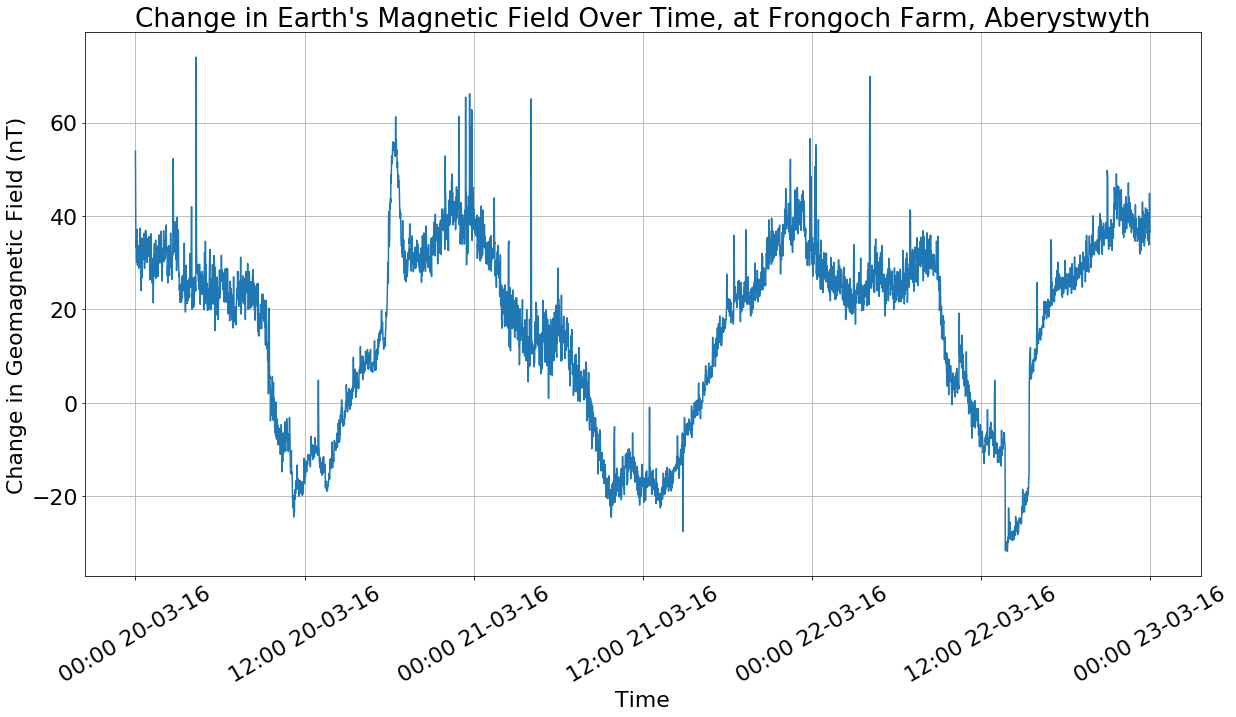

In [16]:
win_min_lim, win_max_lim = np.datetime64('2016-03-20'), np.datetime64('2016-03-23')
win = all_mag_dat.loc[win_min_lim:win_max_lim]
plt.figure(figsize=(20,10))
plt.title("Change in Earth's Magnetic Field Over Time, at Frongoch Farm, Aberystwyth")
plt.grid()
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %d-%m-%y'))
plt.plot(win.loc[win["mag_field"] > -100, "mag_field"])
plt.xlabel("Time")
plt.ylabel("Change in Geomagnetic Field (nT)")

### 7. Including IGRF data with magnetometer readings.

The absolute magnetic field strength can be calculated using the IGRF model. This can be using the [python interface](https://github.com/scivision/igrf12) to the IGRF12 fortran script. Other required details, such as the latitude, longitude and elevation above sea level (in metres) of the sensor is provided in `frongoch_sensor_details.json`. Note that the elevation needs converting to km.

In [17]:
# Open the frongoch sensor details.
with open("frongoch_sensor_details.json", 'r') as frg_inf_file:
    frg_info = json.load(frg_inf_file)

# Downsample, because igrf results don't significantly over 1 day or less and the model is slow to process.
mag_dat_1d_times = all_mag_dat.resample("1d").first()
# Get results from model. This only selects the magnitude of the magnetic field from the data.
mag_dat_1d_times["igrf"] = mag_dat_1d_times.index.map(lambda dt: 
                                                      float(igrf12.igrf(dt,
                                                                      glat=frg_info["latitude"],
                                                                      glon=frg_info["longitude"],
                                                                      alt_km=frg_info["elevation"]/1000)["total"])).astype(np.float32)
# Upsample, and add to original data
all_mag_dat["igrf"] = mag_dat_1d_times["igrf"].resample('1T').ffill()

Check the IGRF results are as we expect (the values for the same day should be the same). Very small step changes (relative to the absolute field) should occur over time.

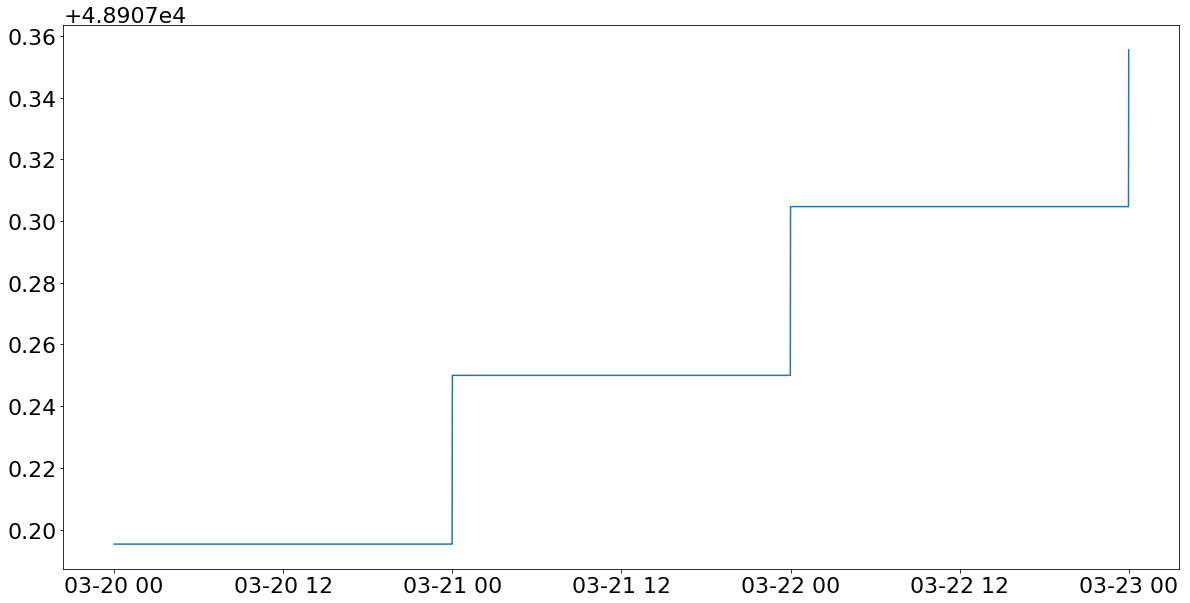

In [18]:
win = all_mag_dat.loc[win_min_lim:win_max_lim]
plt.figure(figsize=(20,10))
plt.plot(win.index, win["igrf"])

Get the total magnetic field by adding the IGRF model and the local variameter readings together.

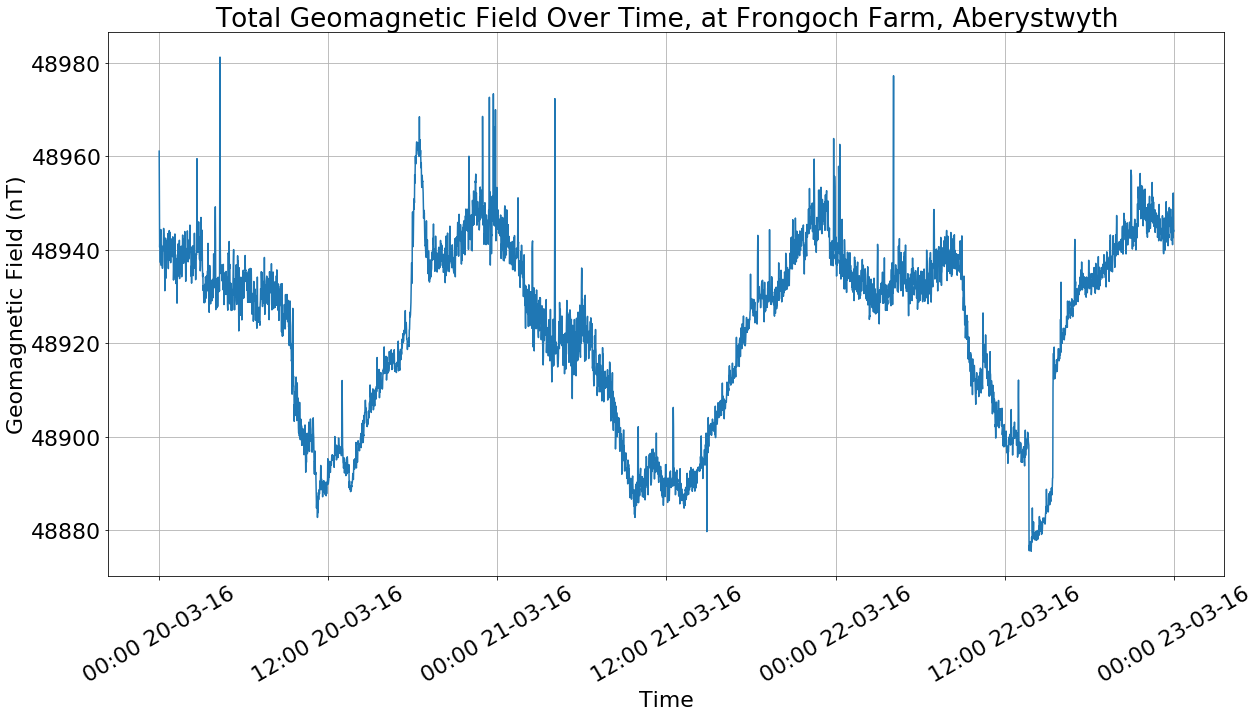

In [19]:
all_mag_dat["total_mag"] = all_mag_dat["igrf"] + all_mag_dat["mag_field"]
win = all_mag_dat.loc[win_min_lim:win_max_lim]
plt.figure(figsize=(20,10))
plt.title("Total Geomagnetic Field Over Time, at Frongoch Farm, Aberystwyth")
plt.grid()
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %d-%m-%y'))
plt.xlabel("Time")
plt.ylabel("Geomagnetic Field (nT)")
plt.plot(win.loc[win["mag_field"] > -100, "total_mag"])

### 8. Compare the local magnetometer results with results from the IGRF model.
Compare the results with Hartland data, by using the jupyter notebook [Getting_HAD_Data](Getting_HAD_Data.ipynb).

### References

\[1\] T. Zagidulin, *REPORT ON FG 3+ FLUXGATE SENSORS TESTING*, 04/06/2018. \[Online\]. Available: https://docs.wixstatic.com/ugd/7034a0_5354433f024e4bbb9df2428c8c49afd0.pdf . Accessed: 16/08/2018